# Evaluate Humans vs Models

In [1]:

from pathlib import Path
import json
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import score_utils

plt.style.use("seaborn-v0_8-darkgrid")
pd.options.display.max_rows = 50
pd.options.display.float_format = lambda x: f"{x:0.2f}"

RUN_IDS: List[str] = [
    "20251013_191510_openai-gpt-5",
    "20251013_191528_x-ai-grok-4-fast",
    "20251014_080823_qwen-qwen3-vl-235b-a22b-thinking",
    "20251020_212534_anthropic-claude-sonnet-4.5",
]

RUNS_DIR = Path("runs")
HUMAN_RESULTS_DIR = Path("human_results")


In [2]:

GRADE_BUCKETS = [
    (3, 4, "Grade 3-4"),
    (5, 6, "Grade 5-6"),
    (7, 8, "Grade 7-8"),
    (9, 10, "Grade 9-10"),
    (11, 13, "Grade 11-13"),
]

GRADE_ORDER = {
    "Grade 3-4": 0,
    "Grade 5-6": 1,
    "Grade 7-8": 2,
    "Grade 9-10": 3,
    "Grade 11-13": 4,
}

def sort_grade_buckets(grades):
    return sorted(grades, key=lambda g: GRADE_ORDER.get(g, 999))


def _model_label_from_run(run_id: str) -> str:
    parts = run_id.split("_", 2)
    return parts[2] if len(parts) >= 3 else run_id


def assign_grade_bucket(exam_id: str) -> str:
    numbers = score_utils.extract_grade_numbers(exam_id)
    if not numbers:
        return "Other/Unknown"
    lo, hi = min(numbers), max(numbers)
    for lower, upper, label in GRADE_BUCKETS:
        if lower <= lo and hi <= upper:
            return label
    return "Other/Unknown"


def load_run_dataframe(run_id: str, runs_dir: Path) -> pd.DataFrame:
    results_path = runs_dir / run_id / "results.filled.parquet"
    df = pd.read_parquet(results_path).copy()

    df["predicted_normalized"] = (
        df["predicted"].fillna("").astype(str).str.strip().str.upper()
    )
    df["has_answer"] = df["predicted_normalized"] != ""
    df["declined"] = df["predicted_normalized"] == score_utils.DECLINED_TOKEN
    df["attempted"] = df["has_answer"] & (~df["declined"])
    df["answered_correctly"] = df["is_correct"].fillna(False).astype(bool)

    df["question_points"] = pd.to_numeric(df["points"], errors="coerce").fillna(0.0)
    df["max_points"] = df["question_points"]
    df["awarded_points"] = np.where(
        df["answered_correctly"],
        df["question_points"],
        np.where(df["attempted"], -score_utils.PENALTY_FACTOR * df["question_points"], 0.0),
    )

    if "multimodal" in df.columns:
        multimodal_flag = df["multimodal"].fillna(False).astype(bool)
    else:
        multimodal_flag = pd.Series(False, index=df.index)
    df["multimodal_flag"] = multimodal_flag.astype(bool)

    df = df.dropna(subset=["year", "group"]).copy()
    df["year"] = df["year"].astype(int)
    df["group"] = df["group"].astype(str)
    df["run_id"] = run_id
    df["model"] = _model_label_from_run(run_id)
    df["grade_bucket"] = df["group"].apply(assign_grade_bucket)
    return df


def aggregate_exam_scores(df: pd.DataFrame) -> pd.DataFrame:
    records: List[Dict[str, Any]] = []
    for (year, exam), g in df.groupby(["year", "group"], dropna=False):
        start_points = score_utils.start_points_for_group(exam)
        net_points = float(g["awarded_points"].sum())
        max_points = float(g["max_points"].sum())
        possible_points = start_points + max_points
        multimodal_share = float(g["multimodal_flag"].mean())
        records.append({
            "run_id": g["run_id"].iloc[0],
            "model": g["model"].iloc[0],
            "year": int(year),
            "exam": str(exam),
            "start_points": start_points,
            "question_points_total": max_points,
            "net_points": net_points,
            "total_score": start_points + net_points,
            "possible_points": possible_points,
            "correct": int(g["answered_correctly"].sum()),
            "attempted": int(g["attempted"].sum()),
            "declined": int(g["declined"].sum()),
            "questions": int(len(g)),
            "multimodal_share": multimodal_share,
            "grade_bucket": assign_grade_bucket(exam),
        })

    exam_df = pd.DataFrame(records)
    exam_df["llm_pct"] = np.where(
        exam_df["possible_points"] > 0,
        100.0 * exam_df["total_score"] / exam_df["possible_points"],
        np.nan,
    )
    return exam_df.sort_values(["year", "exam", "model"]).reset_index(drop=True)


def compute_bin_midpoints(bins: Optional[List[Dict[str, Any]]], grade_id: Optional[str] = None) -> Optional[List[float]]:
    if not bins:
        return None
    midpoints: List[float] = []
    for b in bins:
        ranges = b.get("ranges_by_grade") if isinstance(b, dict) else None
        if ranges and grade_id in ranges:
            r = ranges[grade_id]
            if r and r.get("min") is not None and r.get("max") is not None:
                midpoints.append((float(r["min"]) + float(r["max"])) / 2)
            else:
                range_default = b.get("range_default", {})
                if range_default and range_default.get("min") is not None and range_default.get("max") is not None:
                    midpoints.append((float(range_default["min"]) + float(range_default["max"])) / 2)
                else:
                    midpoints.append(float(b.get("mid", 0.0)))
        else:
            range_default = b.get("range_default", {})
            if range_default and range_default.get("min") is not None and range_default.get("max") is not None:
                midpoints.append((float(range_default["min"]) + float(range_default["max"])) / 2)
            elif b.get("mid") is not None:
                midpoints.append(float(b["mid"]))
    return midpoints if midpoints else None


def percentile_from_distribution(score: float, counts, bins, midpoints) -> float:
    if counts is None or midpoints is None:
        return float("nan")
    counts = np.asarray(counts, dtype=float)
    midpoints = np.asarray(midpoints, dtype=float)
    if counts.size == 0 or midpoints.size == 0 or counts.sum() <= 0:
        return float("nan")
    order = np.argsort(midpoints)
    midpoints = midpoints[order]
    counts = counts[order]
    cumulative = np.cumsum(counts) / counts.sum()
    idx = np.searchsorted(midpoints, score, side="right") - 1
    idx = np.clip(idx, 0, len(cumulative) - 1)
    return float(cumulative[idx] * 100.0)


def compute_mean_from_distribution(counts, midpoints) -> Optional[float]:
    if counts is None or midpoints is None:
        return None
    counts = np.asarray(counts, dtype=float)
    midpoints = np.asarray(midpoints, dtype=float)
    if counts.size == 0 or midpoints.size == 0 or counts.sum() <= 0:
        return None
    if counts.size != midpoints.size:
        return None
    weighted_sum = np.sum(counts * midpoints)
    total_count = np.sum(counts)
    if total_count <= 0:
        return None
    return float(weighted_sum / total_count)


def load_human_baselines(results_dir: Path):
    records: List[Dict[str, Any]] = []
    lookup_by_grade: Dict[Tuple[int, str], Dict[str, Any]] = {}
    lookup_by_members: Dict[Tuple[int, Tuple[int, ...]], Dict[str, Any]] = {}
    raw_records: Dict[Tuple[int, str], Dict[str, Any]] = {}

    for json_path in sorted(results_dir.glob("human_baseline_*.json")):
        with json_path.open("r", encoding="utf-8") as fh:
            data = json.load(fh)
        year = int(data["year"])
        grades = {g["id"]: g for g in data.get("grades", [])}
        totals = data.get("totals_by_grade", {})
        avg_scores = data.get("avg_score_by_grade", {})
        counts_by_grade = data.get("counts_by_grade", {})
        bins = data.get("bins", [])

        for grade_id, total_students in totals.items():
            if grade_id == "overall":
                continue
            meta = grades.get(grade_id, {})
            members = meta.get("members") or [int(grade_id) if grade_id.isdigit() else grade_id]
            
            avg_score = avg_scores.get(grade_id)
            if avg_score is None:
                counts = counts_by_grade.get(grade_id)
                midpoints = compute_bin_midpoints(bins, str(grade_id))
                avg_score = compute_mean_from_distribution(counts, midpoints)
            
            record = {
                "year": year,
                "grade_id": str(grade_id),
                "grade_members": ",".join(str(m) for m in members),
                "avg_score": avg_score,
                "max_points": meta.get("max_points"),
                "total_students": total_students,
                "members": tuple(int(m) for m in members if isinstance(m, (int, float))),
            }
            records.append(record)

            grade_key = (year, str(grade_id))
            lookup_by_grade[grade_key] = {
                "avg": record["avg_score"],
                "max_points": record["max_points"],
                "total_students": total_students,
                "grade_id": str(grade_id),
                "members": record["members"],
            }
            members_tuple = tuple(sorted(record["members"]))
            lookup_by_members[(year, members_tuple)] = lookup_by_grade[grade_key]

            raw_records[grade_key] = {
                "counts": counts_by_grade.get(grade_id),
                "bins": bins,
                "bin_midpoints": compute_bin_midpoints(bins, str(grade_id)),
                "max_points": record["max_points"],
            }

    human_df = pd.DataFrame(records)
    human_lookup = {"by_grade": lookup_by_grade, "by_members": lookup_by_members, "raw_records": raw_records}
    return human_df, human_lookup, raw_records


def resolve_human_stats(year: int, exam_id: str, human_lookup, raw_records):
    by_grade = human_lookup["by_grade"]
    by_members = human_lookup["by_members"]
    grade_numbers = sorted(score_utils.extract_grade_numbers(exam_id))
    if not grade_numbers:
        return {}

    year = int(year)
    
    grade_key = (year, exam_id)
    if grade_key in by_grade:
        rec = by_grade[grade_key]
        grade_id = rec["grade_id"]
        raw = raw_records.get((year, grade_id), {})
        return {
            "avg": rec.get("avg"),
            "max_points": rec.get("max_points"),
            "counts": raw.get("counts"),
            "bins": raw.get("bins"),
            "bin_midpoints": raw.get("bin_midpoints"),
            "grades_used": [grade_id],
            "match_type": "grade_id_exact",
        }
    
    members_key = (year, tuple(grade_numbers))
    direct = by_members.get(members_key)
    if direct:
        grade_id = direct["grade_id"]
        raw = raw_records.get((year, grade_id), {})
        return {
            "avg": direct.get("avg"),
            "max_points": direct.get("max_points"),
            "counts": raw.get("counts"),
            "bins": raw.get("bins"),
            "bin_midpoints": raw.get("bin_midpoints"),
            "grades_used": [grade_id],
            "match_type": "members_exact",
        }

    selected = []
    remaining = set(grade_numbers)
    
    for key, rec in by_grade.items():
        if key[0] != year:
            continue
        members = set(rec.get("members") or [])
        if members and members <= remaining:
            selected.append(rec)
            remaining -= members
    
    if remaining:
        for key, rec in by_grade.items():
            if key[0] != year:
                continue
            members = set(rec.get("members") or [])
            overlap = members & remaining
            if overlap and not any(set(s.get("members") or []) == members for s in selected):
                selected.append(rec)
                remaining -= overlap
        
        if remaining:
            remaining = set(grade_numbers) - set.union(*(set(rec.get("members") or []) for rec in selected), set())
    
    if not selected or remaining:
        return {}

    total_students = sum(rec.get("total_students", 0) or 0 for rec in selected)
    if total_students > 0:
        weighted_avg = sum((rec.get("avg") or 0) * (rec.get("total_students") or 0) for rec in selected) / total_students
    else:
        weighted_avg = float(np.nanmean([rec.get("avg") for rec in selected]))
    max_points = float(np.nanmean([rec.get("max_points") for rec in selected]))

    counts_accum = None
    bins_ref = None
    mid_ref = None
    for rec in selected:
        grade_id = rec["grade_id"]
        raw = raw_records.get((year, grade_id), {})
        counts = raw.get("counts")
        if counts is None:
            continue
        counts = np.asarray(counts, dtype=float)
        if counts_accum is None:
            counts_accum = counts.copy()
            bins_ref = raw.get("bins")
            mid_ref = raw.get("bin_midpoints")
        else:
            counts_accum = counts_accum + counts
    return {
        "avg": weighted_avg,
        "max_points": max_points,
        "counts": counts_accum.tolist() if counts_accum is not None else None,
        "bins": bins_ref,
        "bin_midpoints": mid_ref,
        "grades_used": [rec["grade_id"] for rec in selected],
        "match_type": "aggregate_components",
    }


In [3]:
print("Checking raw run data before aggregation:")
print(f"RUN_IDS: {RUN_IDS}")
for run_id in RUN_IDS:
    run_df = load_run_dataframe(run_id, RUNS_DIR)
    print(f"\n{run_id}:")
    print(f"  Years: {sorted(run_df['year'].unique())}")
    print(f"  Unique exams: {sorted(run_df['group'].unique())}")
    early_data = run_df[run_df['year'].between(2001, 2012)]
    if len(early_data) > 0:
        print(f"  Rows for 2001-2012: {len(early_data)}")
        print(f"  Exams in 2001-2012: {sorted(early_data['group'].unique())}")
    else:
        print(f"  No data for 2001-2012")


Checking raw run data before aggregation:
RUN_IDS: ['20251013_191510_openai-gpt-5', '20251013_191528_x-ai-grok-4-fast', '20251014_080823_qwen-qwen3-vl-235b-a22b-thinking', '20251020_212534_anthropic-claude-sonnet-4.5']

20251013_191510_openai-gpt-5:
  Years: [np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
  Unique exams: ['11-13', '3-4', '5-6', '7-8', '9-10']
  Rows for 2001-2012: 1682
  Exams in 2001-2012: ['11-13', '3-4', '5-6', '7-8', '9-10']

20251013_191528_x-ai-grok-4-fast:
  Years: [np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64

In [4]:

exam_dfs: List[pd.DataFrame] = []
for run_id in RUN_IDS:
    run_df = load_run_dataframe(run_id, RUNS_DIR)
    exam_df = aggregate_exam_scores(run_df)
    exam_dfs.append(exam_df)

all_exam_scores = pd.concat(exam_dfs, ignore_index=True).sort_values(["year", "exam", "model"]).reset_index(drop=True)

exam_avg = (
    all_exam_scores.groupby(["year", "exam"], as_index=False)
    .agg({
        "total_score": "mean",
        "net_points": "mean",
        "start_points": "first",
        "question_points_total": "first",
        "possible_points": "first",
        "correct": "mean",
        "attempted": "mean",
        "declined": "mean",
        "questions": "first",
        "multimodal_share": "mean",
        "grade_bucket": "first",
        "run_id": "nunique",
    })
    .rename(columns={"run_id": "run_count"})
)
exam_avg["llm_pct"] = np.where(
    exam_avg["possible_points"] > 0,
    100.0 * exam_avg["total_score"] / exam_avg["possible_points"],
    np.nan,
)

llm_spread = (
    all_exam_scores.groupby(["year", "exam"])["llm_pct"]
    .agg(llm_pct_std="std", llm_pct_min="min", llm_pct_max="max")
    .reset_index()
)
exam_avg = exam_avg.merge(llm_spread, on=["year", "exam"], how="left")


In [5]:
print("Checking LLM evaluation data for years 2001-2012:")
print(f"Years in all_exam_scores: {sorted(all_exam_scores['year'].unique())}")
early_years = all_exam_scores[all_exam_scores['year'].between(2001, 2012)]
print(f"\nRows for years 2001-2012: {len(early_years)}")
if len(early_years) > 0:
    print("\nUnique exams in years 2001-2012:")
    print(early_years[['year', 'exam', 'grade_bucket']].drop_duplicates().sort_values(['year', 'exam']))
else:
    print("\nNo data found for years 2001-2012!")
    print("\nThis suggests the LLM evaluation runs don't include years 2001-2012")
    print("Let's check what years are in the runs:")

print("\n" + "="*80)
print("Checking human baseline files:")
baseline_files = sorted(HUMAN_RESULTS_DIR.glob("human_baseline_*.json"))
print(f"Total baseline files: {len(baseline_files)}")
print(f"Years: {[int(f.stem.split('_')[-1]) for f in baseline_files]}")

print("\n" + "="*80)
print("Sample of years available in exam_avg:")
print(exam_avg[['year', 'exam', 'grade_bucket']].drop_duplicates().sort_values(['year', 'exam']).head(20))


Checking LLM evaluation data for years 2001-2012:
Years in all_exam_scores: [np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Rows for years 2001-2012: 240

Unique exams in years 2001-2012:
     year   exam grade_bucket
60   2001  11-13  Grade 11-13
64   2001    3-4    Grade 3-4
68   2001    5-6    Grade 5-6
72   2001    7-8    Grade 7-8
76   2001   9-10   Grade 9-10
..    ...    ...          ...
280  2012  11-13  Grade 11-13
284  2012    3-4    Grade 3-4
288  2012    5-6    Grade 5-6
292  2012    7-8    Grade 7-8
296  2012   9-10   Grade 9-10

[60 rows x 3 columns]

Checking human baseline fi

In [6]:
human_df, human_lookup, raw_human_records = load_human_baselines(HUMAN_RESULTS_DIR)


In [7]:
print("Exam labels in dataset:")
print(all_exam_scores[all_exam_scores["grade_bucket"] == "Grade 11-13"]["exam"].unique())

Exam labels in dataset:
['11-13']


In [8]:
comparison_rows: List[Dict[str, Any]] = []
for row in exam_avg.itertuples(index=False):
    stats = resolve_human_stats(int(row.year), row.exam, human_lookup, raw_human_records)
    if not stats:
        continue
    human_avg = stats.get("avg")
    human_max = stats.get("max_points")
    if human_avg in (None, 0) or human_max in (None, 0):
        continue

    llm_score = float(row.total_score)
    llm_possible = float(row.possible_points)
    if llm_possible and human_max and human_max != llm_possible:
        llm_scaled = llm_score / llm_possible * human_max
    else:
        llm_scaled = llm_score

    percentile = percentile_from_distribution(
        llm_scaled,
        stats.get("counts"),
        stats.get("bins"),
        stats.get("bin_midpoints"),
    )

    comparison_rows.append({
        "year": int(row.year),
        "exam": row.exam,
        "run_count": int(row.run_count),
        "llm_pct": row.llm_pct,
        "llm_pct_std": row.llm_pct_std,
        "human_pct": human_avg / human_max * 100.0,
        "delta_pp": row.llm_pct - human_avg / human_max * 100.0,
        "llm_percentile_vs_humans": percentile,
        "grade_bucket": row.grade_bucket,
        "multimodal_share": row.multimodal_share,
        "grades_used": ",".join(stats.get("grades_used", [])),
        "match_type": stats.get("match_type"),
    })

comparison_df = pd.DataFrame(comparison_rows).sort_values(["year", "exam"]).reset_index(drop=True)


In [9]:

base_structure_df = load_run_dataframe(RUN_IDS[0], RUNS_DIR)
structure_df = (
    base_structure_df.groupby(["year", "group"], as_index=False)
    .apply(lambda g: pd.Series({
        "n_items": len(g),
        "points_total": float(g["question_points"].sum()),
        "n_3pt": int((g["question_points"] == 3).sum()),
        "n_4pt": int((g["question_points"] == 4).sum()),
        "n_5pt": int((g["question_points"] >= 5).sum()),
        "multimodal_share": float(g["multimodal_flag"].mean()),
    }))
    .reset_index()
    .rename(columns={"group": "exam"})
)
structure_df["grade_bucket"] = structure_df["exam"].apply(assign_grade_bucket)
structure_df["share_3pt"] = structure_df["n_3pt"] / structure_df["n_items"]
structure_df["share_4pt"] = structure_df["n_4pt"] / structure_df["n_items"]
structure_df["share_5pt"] = structure_df["n_5pt"] / structure_df["n_items"]

model_exam = all_exam_scores[[
    "year",
    "exam",
    "model",
    "llm_pct",
    "questions",
    "attempted",
    "declined",
    "grade_bucket",
]].copy()
model_exam["attempt_rate"] = model_exam["attempted"] / model_exam["questions"]
model_exam["decline_rate"] = model_exam["declined"] / model_exam["questions"]

index_cols = ["year", "exam", "grade_bucket"]
model_pct_wide = model_exam.pivot_table(index=index_cols, columns="model", values="llm_pct")

model_sum = model_pct_wide.sum(axis=1, min_count=1)
model_counts = (~model_pct_wide.isna()).sum(axis=1).astype(int)
ensemble_equal = model_sum / model_counts

anchor_model = "openai-gpt-5"
anchor_pct = model_pct_wide[anchor_model] if anchor_model in model_pct_wide.columns else pd.Series(np.nan, index=model_pct_wide.index)

loo_series = {}
for model in model_pct_wide.columns:
    numer = model_sum - model_pct_wide[model]
    denom = model_counts - model_pct_wide[model].notna().astype(int)
    loo = numer / denom
    loo = loo.where(denom > 0, model_pct_wide[model])
    loo = loo.where(model_pct_wide[model].notna(), ensemble_equal)
    loo_series[f"ensemble_pct_equal_loo_{model}"] = loo

ensemble_df = pd.DataFrame({
    "ensemble_pct_equal": ensemble_equal,
    "model_count": model_counts,
    "anchor_pct": anchor_pct,
})
for key, val in loo_series.items():
    ensemble_df[key] = val
ensemble_df = ensemble_df.reset_index()

analysis_base = (
    ensemble_df
    .merge(structure_df, on=["year", "exam", "grade_bucket"], how="left")
    .merge(comparison_df[["year", "exam", "grade_bucket", "human_pct"]], on=["year", "exam", "grade_bucket"], how="inner")
)
analysis_base["_grade_sort"] = analysis_base["grade_bucket"].map(GRADE_ORDER)
analysis_base = analysis_base.sort_values(["_grade_sort", "year", "exam"]).drop("_grade_sort", axis=1).reset_index(drop=True)


/var/folders/49/b5vrbq2n2w7_v77gnnpj8h7c0000gn/T/ipykernel_57491/1144392496.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [10]:

def _z_transform(series: pd.Series) -> pd.Series:
    mean = series.mean()
    std = series.std(ddof=0)
    if std == 0 or np.isnan(std):
        return series * 0.0
    return (series - mean) / std

analysis_base["human_z"] = analysis_base.groupby("grade_bucket")["human_pct"].transform(_z_transform)
analysis_base["human_difficulty"] = -analysis_base["human_z"]
analysis_base["ensemble_equal_z"] = analysis_base.groupby("grade_bucket")["ensemble_pct_equal"].transform(_z_transform)
analysis_base["difficulty_equal"] = -analysis_base["ensemble_equal_z"]
analysis_base["anchor_z"] = analysis_base.groupby("grade_bucket")["anchor_pct"].transform(_z_transform)
analysis_base["difficulty_anchor"] = -analysis_base["anchor_z"]

analysis_base["ensemble_pct_comp_resid"] = np.nan
feature_cols = ["multimodal_share", "share_5pt", "share_3pt", "n_items"]
for grade, subset in analysis_base.groupby("grade_bucket"):
    idx = subset.index
    X = analysis_base.loc[idx, feature_cols].to_numpy(dtype=float)
    y = analysis_base.loc[idx, "ensemble_pct_equal"].to_numpy(dtype=float)
    mask = (~np.isnan(X).any(axis=1)) & (~np.isnan(y))
    valid_idx = idx[mask]
    if len(valid_idx) == 0:
        continue
    X_valid = np.column_stack([np.ones(len(valid_idx)), X[mask]])
    y_valid = y[mask]
    if len(valid_idx) >= X_valid.shape[1]:
        coef, *_ = np.linalg.lstsq(X_valid, y_valid, rcond=None)
        resid = y_valid - X_valid @ coef
    else:
        resid = y_valid - y_valid.mean()
    analysis_base.loc[valid_idx, "ensemble_pct_comp_resid"] = resid

analysis_base["ensemble_comp_z"] = analysis_base.groupby("grade_bucket")["ensemble_pct_comp_resid"].transform(_z_transform)
analysis_base["difficulty_comp"] = -analysis_base["ensemble_comp_z"]

loo_cols = [c for c in analysis_base.columns if c.startswith("ensemble_pct_equal_loo_")]
for col in loo_cols:
    diff_col = col.replace("ensemble_pct_equal_loo_", "difficulty_loo_")
    analysis_base[diff_col] = -analysis_base.groupby("grade_bucket")[col].transform(_z_transform)

params = analysis_base.groupby("grade_bucket")["ensemble_pct_equal"].agg(["mean", "std"]).rename(columns={"mean": "grade_mean", "std": "grade_std"})
grade_params = params.to_dict("index")


def _difficulty_from_pct(row):
    param = grade_params.get(row["grade_bucket"])
    if not param or param["grade_std"] in (0, None) or np.isnan(param["grade_std"]):
        return 0.0
    return -(row["llm_pct"] - param["grade_mean"]) / param["grade_std"]

model_exam["difficulty_equal_scale"] = model_exam.apply(_difficulty_from_pct, axis=1)


def _spread_stats(g: pd.DataFrame) -> pd.Series:
    std = float(g["difficulty_equal_scale"].std(ddof=0))
    return pd.Series({
        "difficulty_equal_std": std,
    })

spread = model_exam.groupby(["year", "exam", "grade_bucket"]).apply(_spread_stats).reset_index()
analysis_base = analysis_base.merge(spread, on=["year", "exam", "grade_bucket"], how="left")
analysis_base["difficulty_equal_std"] = analysis_base["difficulty_equal_std"].fillna(0.0)
analysis_base["model_count"] = analysis_base["model_count"].astype(int)

analysis_base["difficulty_equal_ci_lo"] = analysis_base["difficulty_equal"] - 1.96 * (analysis_base["difficulty_equal_std"] / np.sqrt(np.maximum(analysis_base["model_count"], 1)))
analysis_base["difficulty_equal_ci_hi"] = analysis_base["difficulty_equal"] + 1.96 * (analysis_base["difficulty_equal_std"] / np.sqrt(np.maximum(analysis_base["model_count"], 1)))

analysis_df = analysis_base.copy()


/var/folders/49/b5vrbq2n2w7_v77gnnpj8h7c0000gn/T/ipykernel_57491/307895016.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spread = model_exam.groupby(["year", "exam", "grade_bucket"]).apply(_spread_stats).reset_index()


In [11]:

_seed = {"value": 0}

def _next_seed() -> int:
    _seed["value"] += 1
    return 2025 + _seed["value"]


def bootstrap_corr(x: np.ndarray, y: np.ndarray, n_boot: int = 2000) -> Tuple[float, float, float]:
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[mask]
    y = y[mask]
    if len(x) < 3 or np.std(x) == 0 or np.std(y) == 0:
        return float("nan"), float("nan"), float("nan")
    obs = float(np.corrcoef(x, y)[0, 1])
    boot = []
    rng = np.random.default_rng(_next_seed())
    for _ in range(n_boot):
        idx = rng.integers(0, len(x), len(x))
        xb = x[idx]
        yb = y[idx]
        if np.std(xb) == 0 or np.std(yb) == 0:
            continue
        boot.append(np.corrcoef(xb, yb)[0, 1])
    if not boot:
        return obs, float("nan"), float("nan")
    boot_arr = np.array(boot, dtype=float)
    return obs, float(np.percentile(boot_arr, 2.5)), float(np.percentile(boot_arr, 97.5))


def bootstrap_slope(years: np.ndarray, values: np.ndarray, n_boot: int = 2000) -> Tuple[float, float, float]:
    mask = (~np.isnan(years)) & (~np.isnan(values))
    years = years[mask]
    values = values[mask]
    if len(years) < 2 or np.std(years) == 0 or np.std(values) == 0:
        return float("nan"), float("nan"), float("nan")
    obs = float(np.polyfit(years, values, 1)[0])
    boot = []
    rng = np.random.default_rng(_next_seed())
    for _ in range(n_boot):
        idx = rng.integers(0, len(years), len(years))
        x = years[idx]
        y = values[idx]
        if np.std(x) == 0 or np.std(y) == 0:
            continue
        boot.append(np.polyfit(x, y, 1)[0])
    if not boot:
        return obs, float("nan"), float("nan")
    boot_arr = np.array(boot, dtype=float)
    return obs, float(np.percentile(boot_arr, 2.5)), float(np.percentile(boot_arr, 97.5))

alignment_rows: List[Dict[str, Any]] = []
slope_rows: List[Dict[str, Any]] = []
loo_rows: List[Dict[str, Any]] = []
anchor_rows: List[Dict[str, Any]] = []

difficulty_cols = {
    "difficulty_equal": "Ensemble (equal)",
    "difficulty_comp": "Ensemble (composition-adjusted)",
    "difficulty_anchor": "Anchor (openai-gpt-5)",
}
loo_cols = [c for c in analysis_df.columns if c.startswith("difficulty_loo_")]

for grade, group in analysis_df.groupby("grade_bucket"):
    group = group.sort_values("year")
    years = group["year"].to_numpy(dtype=float)
    human = group["human_difficulty"].to_numpy(dtype=float)

    human_slope, human_lo, human_hi = bootstrap_slope(years, human)
    slope_rows.append({
        "grade_bucket": grade,
        "series": "Human",
        "slope": human_slope,
        "ci_lo": human_lo,
        "ci_hi": human_hi,
    })

    for col, label in difficulty_cols.items():
        diff = group[col].to_numpy(dtype=float)
        corr, lo, hi = bootstrap_corr(human, diff)
        alignment_rows.append({
            "grade_bucket": grade,
            "series": label,
            "corr": corr,
            "ci_lo": lo,
            "ci_hi": hi,
        })
        slope_val, slo_lo, slo_hi = bootstrap_slope(years, diff)
        slope_rows.append({
            "grade_bucket": grade,
            "series": label,
            "slope": slope_val,
            "ci_lo": slo_lo,
            "ci_hi": slo_hi,
        })

    for col in loo_cols:
        diff = group[col].to_numpy(dtype=float)
        corr, lo, hi = bootstrap_corr(human, diff)
        max_delta = float(np.nanmax(np.abs(diff - group["difficulty_equal"].to_numpy(dtype=float))))
        loo_rows.append({
            "grade_bucket": grade,
            "model_omitted": col.replace("difficulty_loo_", ""),
            "corr": corr,
            "ci_lo": lo,
            "ci_hi": hi,
            "max_abs_delta_vs_equal": max_delta,
        })

    anchor_corr, anchor_lo, anchor_hi = bootstrap_corr(
        group["difficulty_equal"].to_numpy(dtype=float),
        group["difficulty_anchor"].to_numpy(dtype=float),
    )
    anchor_rows.append({
        "grade_bucket": grade,
        "corr": anchor_corr,
        "ci_lo": anchor_lo,
        "ci_hi": anchor_hi,
    })

alignment_stats = pd.DataFrame(alignment_rows)
slope_stats = pd.DataFrame(slope_rows)
loo_stats = pd.DataFrame(loo_rows)
anchor_stats = pd.DataFrame(anchor_rows)

grade_sort_key = lambda x: GRADE_ORDER.get(x, 999)

alignment_stats["_sort_key"] = alignment_stats["grade_bucket"].map(grade_sort_key)
alignment_stats = alignment_stats.sort_values(["_sort_key", "series"]).drop("_sort_key", axis=1).reset_index(drop=True)

slope_stats["_sort_key"] = slope_stats["grade_bucket"].map(grade_sort_key)
slope_stats = slope_stats.sort_values(["_sort_key", "series"]).drop("_sort_key", axis=1).reset_index(drop=True)

loo_stats["_sort_key"] = loo_stats["grade_bucket"].map(grade_sort_key)
loo_stats = loo_stats.sort_values(["_sort_key", "model_omitted"]).drop("_sort_key", axis=1).reset_index(drop=True)

anchor_stats["_sort_key"] = anchor_stats["grade_bucket"].map(grade_sort_key)
anchor_stats = anchor_stats.sort_values("_sort_key").drop("_sort_key", axis=1).reset_index(drop=True)


In [12]:
print("Leave-One-Out (LOO) Analysis:")
print("Maximum deviation from equal-weight ensemble across all grade buckets:")
print(loo_stats.groupby("model_omitted")["max_abs_delta_vs_equal"].agg(["mean", "max"]).round(3))
print("\nCorrelation with human difficulty (by grade bucket):")
print(loo_stats[["grade_bucket", "model_omitted", "corr", "max_abs_delta_vs_equal"]].sort_values(["grade_bucket", "max_abs_delta_vs_equal"]))


Leave-One-Out (LOO) Analysis:
Maximum deviation from equal-weight ensemble across all grade buckets:
                                  mean  max
model_omitted                              
anthropic-claude-sonnet-4.5       0.54 1.08
openai-gpt-5                      0.39 0.65
qwen-qwen3-vl-235b-a22b-thinking  0.35 0.51
x-ai-grok-4-fast                  0.41 0.64

Correlation with human difficulty (by grade bucket):
   grade_bucket                     model_omitted  corr  \
18  Grade 11-13  qwen-qwen3-vl-235b-a22b-thinking  0.04   
19  Grade 11-13                  x-ai-grok-4-fast -0.03   
17  Grade 11-13                      openai-gpt-5  0.04   
16  Grade 11-13       anthropic-claude-sonnet-4.5  0.05   
2     Grade 3-4  qwen-qwen3-vl-235b-a22b-thinking  0.16   
0     Grade 3-4       anthropic-claude-sonnet-4.5  0.14   
1     Grade 3-4                      openai-gpt-5  0.09   
3     Grade 3-4                  x-ai-grok-4-fast  0.16   
5     Grade 5-6                      openai-gpt-5 

In [13]:

print("Years available for Grade 11-13:")
grade_11_13 = analysis_df[analysis_df["grade_bucket"] == "Grade 11-13"]
print(sorted(grade_11_13["year"].unique()))
print(f"\nTotal rows for Grade 11-13: {len(grade_11_13)}")
print("\nUnique exams for Grade 11-13:")
print(grade_11_13["exam"].unique())

print("\n" + "="*80)
print("Checking exam labels and grade extraction:")
for exam in grade_11_13["exam"].unique()[:5]:
    grades = score_utils.extract_grade_numbers(exam)
    print(f"Exam: {exam} -> Grades: {grades}")

print("\n" + "="*80)
print("Year coverage by grade bucket:")
for grade in sorted(analysis_df["grade_bucket"].unique()):
    years = sorted(analysis_df[analysis_df["grade_bucket"] == grade]["year"].unique())
    print(f"{grade}: {years[0]}-{years[-1]} ({len(years)} years)")



Years available for Grade 11-13:
[np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Total rows for Grade 11-13: 23

Unique exams for Grade 11-13:
['11-13']

Checking exam labels and grade extraction:
Exam: 11-13 -> Grades: (11, 13)

Year coverage by grade bucket:
Grade 11-13: 2001-2025 (23 years)
Grade 3-4: 2001-2025 (23 years)
Grade 5-6: 2001-2025 (23 years)
Grade 7-8: 2001-2025 (23 years)
Grade 9-10: 2001-2025 (23 years)


/var/folders/49/b5vrbq2n2w7_v77gnnpj8h7c0000gn/T/ipykernel_57491/1569825234.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.97)


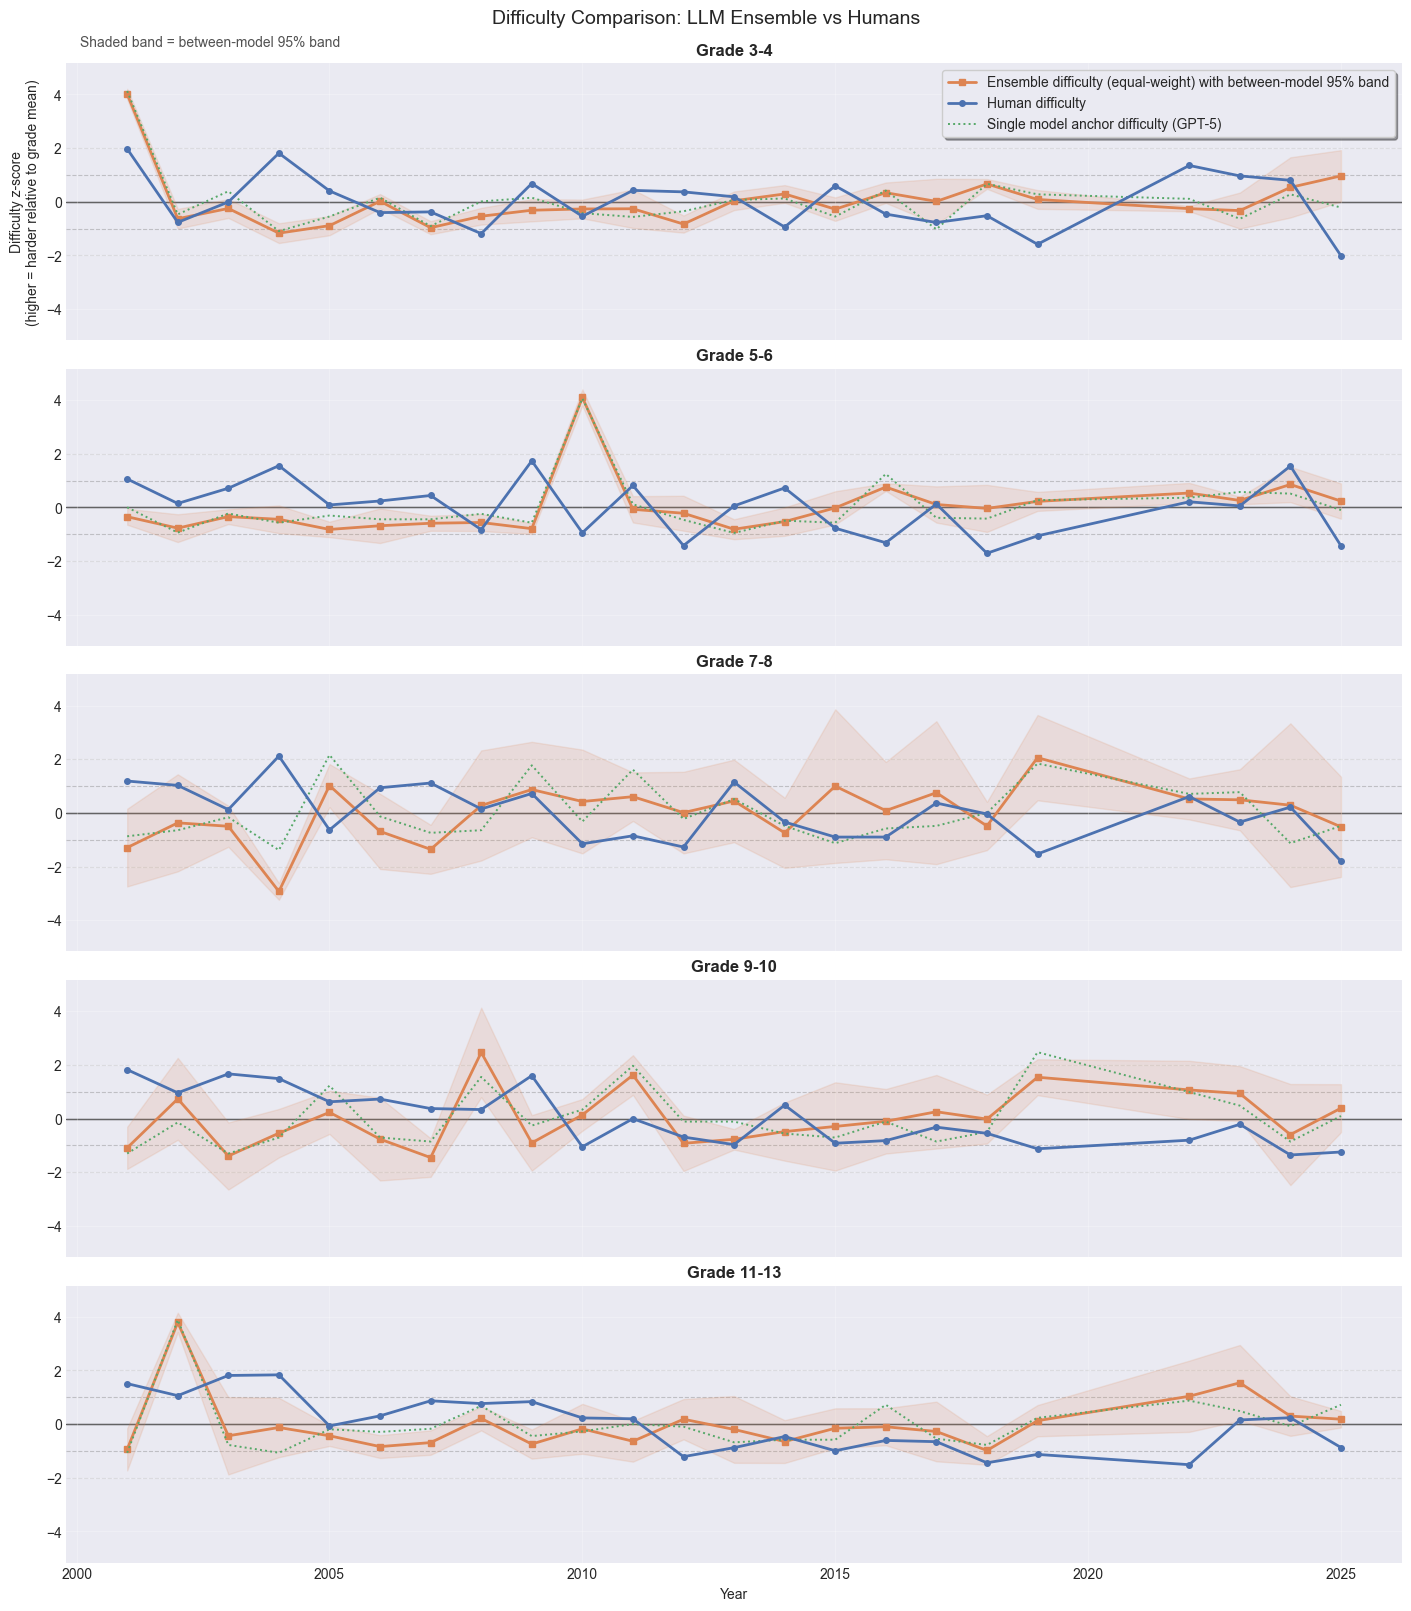

In [14]:

loo_cols = [c for c in analysis_df.columns if c.startswith("difficulty_loo_")]
grades = sort_grade_buckets(analysis_df["grade_bucket"].unique().tolist())
fig, axes = plt.subplots(len(grades), 1, sharex=True, figsize=(14, 3.2 * len(grades)), constrained_layout=True)
if len(grades) == 1:
    axes = [axes]

main_series_for_limits = [
    analysis_df["human_difficulty"],
    analysis_df["difficulty_equal"],
    analysis_df["difficulty_equal_ci_lo"],
    analysis_df["difficulty_equal_ci_hi"],
]
finite_values = np.concatenate([
    s.to_numpy(dtype=float)[~np.isnan(s.to_numpy(dtype=float))]
    for s in main_series_for_limits
    if not s.empty
])
ymin_raw = float(finite_values.min()) if finite_values.size else -2.0
ymax_raw = float(finite_values.max()) if finite_values.size else 2.0
yrange = ymax_raw - ymin_raw
ymin = max(-25.0, ymin_raw - 0.1 * yrange)
ymax = min(25.0, ymax_raw + 0.1 * yrange)

# Make y-axis symmetrical
max_abs = max(abs(ymin), abs(ymax))
ymin = -max_abs
ymax = max_abs

for idx, (grade, ax) in enumerate(zip(grades, axes)):
    subset = analysis_df[analysis_df["grade_bucket"] == grade].sort_values("year")
    x = subset["year"].to_numpy(dtype=float)

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.0, alpha=0.8, zorder=0)
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=0.8, alpha=0.4, zorder=0)
    ax.axhline(y=-1, color='gray', linestyle='--', linewidth=0.8, alpha=0.4, zorder=0)
    ax.axhline(y=2, color='gray', linestyle='--', linewidth=0.8, alpha=0.25, zorder=0)
    ax.axhline(y=-2, color='gray', linestyle='--', linewidth=0.8, alpha=0.25, zorder=0)

    ax.fill_between(
        x,
        subset["difficulty_equal_ci_lo"],
        subset["difficulty_equal_ci_hi"],
        color="#DD8452",
        alpha=0.15,
        zorder=1,
    )

    ax.plot(
        x,
        subset["difficulty_equal"],
        color="#DD8452",
        linewidth=2.0,
        marker="s",
        markersize=4,
        label="Ensemble difficulty (equal-weight) with between-model 95% band",
        zorder=3,
    )
    ax.plot(
        x,
        subset["human_difficulty"],
        color="#4C72B0",
        linewidth=2.0,
        marker="o",
        markersize=4,
        label="Human difficulty",
        zorder=4,
    )

    anchor_label = "Single model anchor difficulty (GPT-5)" if idx == 0 else None
    ax.plot(x, subset["difficulty_anchor"], linestyle=":", linewidth=1.4, color="#55A868", label=anchor_label, zorder=3)

    ax.set_title(grade, fontsize=12, fontweight='bold')
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.25)
    if idx == 0:
        ax.set_ylabel("Difficulty z-score\n(higher = harder relative to grade mean)")
        ax.text(0.01, 1.06, "Shaded band = between-model 95% band", transform=ax.transAxes, fontsize=10, alpha=0.8)

axes[-1].set_xlabel("Year")
axes[0].legend(loc="upper right", frameon=True, ncol=1, fancybox=True, shadow=True)
fig.suptitle("Difficulty Comparison: LLM Ensemble vs Humans", fontsize=14)
plt.subplots_adjust(top=0.97)
plt.show()


Grade 3-4: 15/23 exams with disagreement (65.2%)
Grade 5-6: 15/23 exams with disagreement (65.2%)
Grade 7-8: 14/23 exams with disagreement (60.9%)
Grade 9-10: 14/23 exams with disagreement (60.9%)
Grade 11-13: 12/23 exams with disagreement (52.2%)

Overall: 70/115 exams with disagreement (60.9%)


/var/folders/49/b5vrbq2n2w7_v77gnnpj8h7c0000gn/T/ipykernel_57491/2866154468.py:101: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.97)


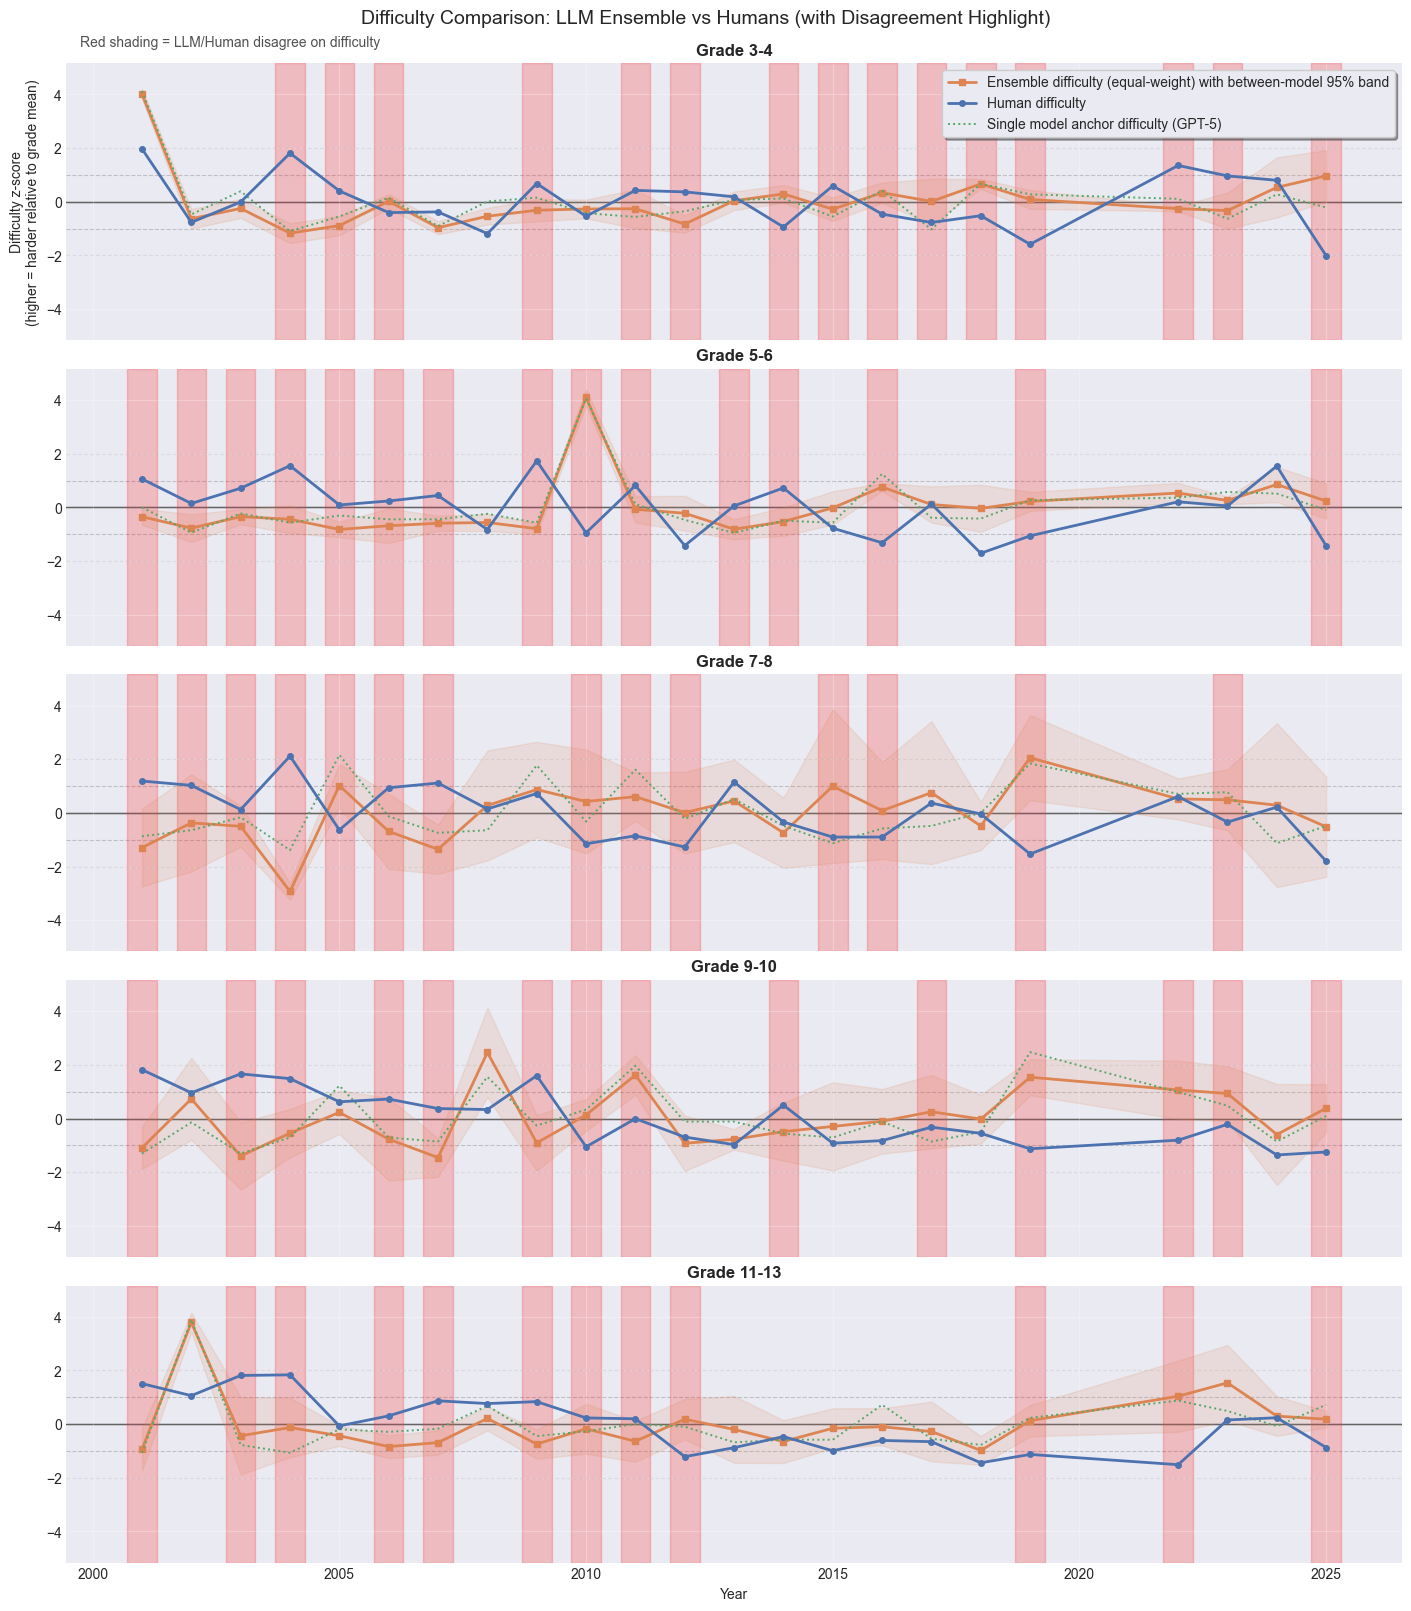

In [15]:
grades = sort_grade_buckets(analysis_df["grade_bucket"].unique().tolist())
fig, axes = plt.subplots(len(grades), 1, sharex=True, figsize=(14, 3.2 * len(grades)), constrained_layout=True)
if len(grades) == 1:
    axes = [axes]

main_series_for_limits = [
    analysis_df["human_difficulty"],
    analysis_df["difficulty_equal"],
    analysis_df["difficulty_equal_ci_lo"],
    analysis_df["difficulty_equal_ci_hi"],
]
finite_values = np.concatenate([
    s.to_numpy(dtype=float)[~np.isnan(s.to_numpy(dtype=float))]
    for s in main_series_for_limits
    if not s.empty
])
ymin_raw = float(finite_values.min()) if finite_values.size else -2.0
ymax_raw = float(finite_values.max()) if finite_values.size else 2.0
yrange = ymax_raw - ymin_raw
ymin = max(-25.0, ymin_raw - 0.1 * yrange)
ymax = min(25.0, ymax_raw + 0.1 * yrange)

max_abs = max(abs(ymin), abs(ymax))
ymin = -max_abs
ymax = max_abs

total_disagreements = 0
total_exams = 0

for idx, (grade, ax) in enumerate(zip(grades, axes)):
    subset = analysis_df[analysis_df["grade_bucket"] == grade].sort_values("year")
    x = subset["year"].to_numpy(dtype=float)
    human_diff = subset["human_difficulty"].to_numpy(dtype=float)
    ensemble_diff = subset["difficulty_equal"].to_numpy(dtype=float)
    
    disagree_mask = ((human_diff > 0) & (ensemble_diff < 0)) | ((human_diff < 0) & (ensemble_diff > 0))
    
    grade_disagreements = np.sum(disagree_mask)
    grade_exams = len(subset)
    total_disagreements += grade_disagreements
    total_exams += grade_exams
    
    print(f"{grade}: {grade_disagreements}/{grade_exams} exams with disagreement ({grade_disagreements/grade_exams*100:.1f}%)")
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.0, alpha=0.8, zorder=0)
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=0.8, alpha=0.4, zorder=0)
    ax.axhline(y=-1, color='gray', linestyle='--', linewidth=0.8, alpha=0.4, zorder=0)
    ax.axhline(y=2, color='gray', linestyle='--', linewidth=0.8, alpha=0.25, zorder=0)
    ax.axhline(y=-2, color='gray', linestyle='--', linewidth=0.8, alpha=0.25, zorder=0)
    
    for i, yr in enumerate(x):
        if disagree_mask[i]:
            ax.axvspan(yr - 0.3, yr + 0.3, color='red', alpha=0.2, zorder=0)
    
    ax.fill_between(
        x,
        subset["difficulty_equal_ci_lo"],
        subset["difficulty_equal_ci_hi"],
        color="#DD8452",
        alpha=0.15,
        zorder=1,
    )
    
    ax.plot(
        x,
        subset["difficulty_equal"],
        color="#DD8452",
        linewidth=2.0,
        marker="s",
        markersize=4,
        label="Ensemble difficulty (equal-weight) with between-model 95% band",
        zorder=3,
    )
    
    ax.plot(
        x,
        subset["human_difficulty"],
        color="#4C72B0",
        linewidth=2.0,
        marker="o",
        markersize=4,
        label="Human difficulty",
        zorder=4,
    )
    
    anchor_label = "Single model anchor difficulty (GPT-5)" if idx == 0 else None
    ax.plot(x, subset["difficulty_anchor"], linestyle=":", linewidth=1.4, color="#55A868", label=anchor_label, zorder=3)
    
    ax.set_title(grade, fontsize=12, fontweight='bold')
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.25)
    if idx == 0:
        ax.set_ylabel("Difficulty z-score\n(higher = harder relative to grade mean)")
        ax.text(0.01, 1.06, "Red shading = LLM/Human disagree on difficulty", transform=ax.transAxes, fontsize=10, alpha=0.8)

print(f"\nOverall: {total_disagreements}/{total_exams} exams with disagreement ({total_disagreements/total_exams*100:.1f}%)")

axes[-1].set_xlabel("Year")
axes[0].legend(loc="upper right", frameon=True, ncol=1, fancybox=True, shadow=True)
fig.suptitle("Difficulty Comparison: LLM Ensemble vs Humans (with Disagreement Highlight)", fontsize=14)
plt.subplots_adjust(top=0.97)
plt.show()


# Standard Candle Analysis

This section evaluates whether LLMs can serve as a reliable "standard candle" for measuring exam difficulty over time. We test:
1. **Calibration**: linear relationship between LLM and human difficulty
2. **Temporal invariance**: stability of the relationship across time
3. **Out-of-sample validation**: predictive power across eras
4. **Decision criteria**: pass/fail thresholds for usability


In [16]:
def bootstrap_regression_coefs(X: np.ndarray, y: np.ndarray, n_boot: int = 2000) -> Dict[str, Tuple[float, float, float]]:
    mask = (~np.isnan(X).any(axis=1)) & (~np.isnan(y))
    X = X[mask]
    y = y[mask]
    
    if len(y) < X.shape[1] + 1:
        return {}
    
    X_design = np.column_stack([np.ones(len(X)), X])
    obs_coef = np.linalg.lstsq(X_design, y, rcond=None)[0]
    
    boot_coefs = []
    rng = np.random.default_rng(_next_seed())
    for _ in range(n_boot):
        idx = rng.integers(0, len(y), len(y))
        X_boot = X_design[idx]
        y_boot = y[idx]
        try:
            coef = np.linalg.lstsq(X_boot, y_boot, rcond=None)[0]
            boot_coefs.append(coef)
        except:
            continue
    
    if not boot_coefs:
        return {}
    
    boot_arr = np.array(boot_coefs)
    result = {}
    coef_names = ["intercept"] + [f"coef_{i}" for i in range(X.shape[1])]
    for i, name in enumerate(coef_names):
        result[name] = (
            float(obs_coef[i]),
            float(np.percentile(boot_arr[:, i], 2.5)),
            float(np.percentile(boot_arr[:, i], 97.5))
        )
    
    y_pred = X_design @ obs_coef
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    result["r2"] = (r2, np.nan, np.nan)
    
    return result


def same_side_rate(x: np.ndarray, y: np.ndarray) -> float:
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[mask]
    y = y[mask]
    if len(x) == 0:
        return float("nan")
    return float(np.mean((x > 0) == (y > 0)))


def peak_trough_recall(x: np.ndarray, y: np.ndarray, threshold: float = 1.0) -> Tuple[float, float]:
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[mask]
    y = y[mask]
    if len(x) == 0:
        return float("nan"), float("nan")
    
    x_peaks = np.abs(x) >= threshold
    if not x_peaks.any():
        return float("nan"), float("nan")
    
    y_peaks = np.abs(y) >= threshold
    same_sign = (x > 0) == (y > 0)
    
    recall = float(np.mean(y_peaks[x_peaks] & same_sign[x_peaks]))
    precision = float(np.mean(x_peaks[y_peaks] & same_sign[y_peaks])) if y_peaks.any() else float("nan")
    
    return recall, precision


In [17]:
calibration_records = []

llm_series_to_test = {
    "anchor": "difficulty_anchor",
    "ensemble_equal": "difficulty_equal",
}

for grade, group in analysis_df.groupby("grade_bucket"):
    group = group.sort_values("year").copy()
    years = group["year"].to_numpy(dtype=float)
    years_centered = years - np.mean(years)
    human = group["human_difficulty"].to_numpy(dtype=float)
    
    for series_name, col_name in llm_series_to_test.items():
        llm = group[col_name].to_numpy(dtype=float)
        
        corr_val, corr_lo, corr_hi = bootstrap_corr(human, llm)
        same_side = same_side_rate(human, llm)
        peak_recall, peak_precision = peak_trough_recall(human, llm, threshold=1.0)
        
        X_calib = llm.reshape(-1, 1)
        calib = bootstrap_regression_coefs(X_calib, human, n_boot=2000)
        
        alpha = calib.get("intercept", (np.nan, np.nan, np.nan))
        beta = calib.get("coef_0", (np.nan, np.nan, np.nan))
        r2_calib = calib.get("r2", (np.nan, np.nan, np.nan))[0]
        
        X_time = np.column_stack([llm, years_centered])
        time_model = bootstrap_regression_coefs(X_time, human, n_boot=2000)
        gamma = time_model.get("coef_1", (np.nan, np.nan, np.nan))
        
        median_year = np.median(years)
        early_mask = years < median_year
        late_mask = years >= median_year
        
        if np.sum(early_mask) >= 3 and np.sum(late_mask) >= 3:
            X_early = llm[early_mask].reshape(-1, 1)
            y_early = human[early_mask]
            early_model = bootstrap_regression_coefs(X_early, y_early, n_boot=2000)
            alpha_early = early_model.get("intercept", (np.nan, np.nan, np.nan))[0]
            beta_early = early_model.get("coef_0", (np.nan, np.nan, np.nan))[0]
            
            X_late = llm[late_mask].reshape(-1, 1)
            y_late = human[late_mask]
            late_model = bootstrap_regression_coefs(X_late, y_late, n_boot=2000)
            alpha_late = late_model.get("intercept", (np.nan, np.nan, np.nan))[0]
            beta_late = late_model.get("coef_0", (np.nan, np.nan, np.nan))[0]
            
            delta_alpha = alpha_late - alpha_early
            delta_beta = beta_late - beta_early
        else:
            alpha_early = beta_early = alpha_late = beta_late = np.nan
            delta_alpha = delta_beta = np.nan
        
        multimodal_share = group["multimodal_share"].to_numpy(dtype=float)
        share_5pt = group["share_5pt"].to_numpy(dtype=float)
        X_comp = np.column_stack([llm, multimodal_share, share_5pt])
        comp_model = bootstrap_regression_coefs(X_comp, human, n_boot=2000)
        beta_comp = comp_model.get("coef_0", (np.nan, np.nan, np.nan))
        
        calibration_records.append({
            "grade_bucket": grade,
            "llm_series": series_name,
            "correlation": corr_val,
            "corr_ci_lo": corr_lo,
            "corr_ci_hi": corr_hi,
            "same_side_rate": same_side,
            "peak_recall": peak_recall,
            "peak_precision": peak_precision,
            "alpha": alpha[0],
            "alpha_ci_lo": alpha[1],
            "alpha_ci_hi": alpha[2],
            "beta": beta[0],
            "beta_ci_lo": beta[1],
            "beta_ci_hi": beta[2],
            "r2": r2_calib,
            "gamma": gamma[0],
            "gamma_ci_lo": gamma[1],
            "gamma_ci_hi": gamma[2],
            "alpha_early": alpha_early,
            "beta_early": beta_early,
            "alpha_late": alpha_late,
            "beta_late": beta_late,
            "delta_alpha": delta_alpha,
            "delta_beta": delta_beta,
            "beta_comp": beta_comp[0],
            "beta_comp_ci_lo": beta_comp[1],
            "beta_comp_ci_hi": beta_comp[2],
        })

calibration_df = pd.DataFrame(calibration_records)
calibration_df["_sort_key"] = calibration_df["grade_bucket"].map(grade_sort_key)
calibration_df = calibration_df.sort_values(["_sort_key", "llm_series"]).drop("_sort_key", axis=1).reset_index(drop=True)


In [18]:
oos_records = []

for grade, group in analysis_df.groupby("grade_bucket"):
    group = group.sort_values("year").copy()
    years = group["year"].to_numpy(dtype=float)
    human = group["human_difficulty"].to_numpy(dtype=float)
    
    median_year = np.median(years)
    early_mask = years < median_year
    late_mask = years >= median_year
    
    if np.sum(early_mask) < 3 or np.sum(late_mask) < 3:
        continue
    
    for series_name, col_name in llm_series_to_test.items():
        llm = group[col_name].to_numpy(dtype=float)
        
        X_train_early = llm[early_mask].reshape(-1, 1)
        y_train_early = human[early_mask]
        X_test_late = llm[late_mask].reshape(-1, 1)
        y_test_late = human[late_mask]
        
        mask_train = (~np.isnan(X_train_early.flatten())) & (~np.isnan(y_train_early))
        mask_test = (~np.isnan(X_test_late.flatten())) & (~np.isnan(y_test_late))
        
        if np.sum(mask_train) >= 2 and np.sum(mask_test) >= 2:
            X_train = np.column_stack([np.ones(np.sum(mask_train)), X_train_early[mask_train]])
            y_train = y_train_early[mask_train]
            coef_early = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
            
            X_test = np.column_stack([np.ones(np.sum(mask_test)), X_test_late[mask_test]])
            y_test = y_test_late[mask_test]
            y_pred = X_test @ coef_early
            
            ss_res = np.sum((y_test - y_pred) ** 2)
            ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
            r2_early_late = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
        else:
            r2_early_late = np.nan
        
        X_train_late = llm[late_mask].reshape(-1, 1)
        y_train_late = human[late_mask]
        X_test_early = llm[early_mask].reshape(-1, 1)
        y_test_early = human[early_mask]
        
        mask_train = (~np.isnan(X_train_late.flatten())) & (~np.isnan(y_train_late))
        mask_test = (~np.isnan(X_test_early.flatten())) & (~np.isnan(y_test_early))
        
        if np.sum(mask_train) >= 2 and np.sum(mask_test) >= 2:
            X_train = np.column_stack([np.ones(np.sum(mask_train)), X_train_late[mask_train]])
            y_train = y_train_late[mask_train]
            coef_late = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
            
            X_test = np.column_stack([np.ones(np.sum(mask_test)), X_test_early[mask_test]])
            y_test = y_test_early[mask_test]
            y_pred = X_test @ coef_late
            
            ss_res = np.sum((y_test - y_pred) ** 2)
            ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
            r2_late_early = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
        else:
            r2_late_early = np.nan
        
        oos_records.append({
            "grade_bucket": grade,
            "llm_series": series_name,
            "oos_r2_early_to_late": r2_early_late,
            "oos_r2_late_to_early": r2_late_early,
            "oos_r2_mean": np.nanmean([r2_early_late, r2_late_early]),
        })

oos_df = pd.DataFrame(oos_records)
oos_df["_sort_key"] = oos_df["grade_bucket"].map(grade_sort_key)
oos_df = oos_df.sort_values(["_sort_key", "llm_series"]).drop("_sort_key", axis=1).reset_index(drop=True)


In [ ]:
THRESHOLDS = {
    "min_correlation": 0.3,
    "min_same_side_rate": 0.5,
    "min_peak_recall": 0.4,
    "max_abs_alpha": 0.3,
    "beta_min": 0.5,
    "beta_max": 1.5,
    "gamma_must_include_zero": True,
    "max_abs_delta_alpha": 0.5,
    "max_abs_delta_beta": 0.5,
    "min_oos_r2": 0.0,
}

decision_records = []

for _, calib_row in calibration_df.iterrows():
    grade = calib_row["grade_bucket"]
    series = calib_row["llm_series"]
    
    oos_row = oos_df[(oos_df["grade_bucket"] == grade) & (oos_df["llm_series"] == series)]
    oos_r2 = oos_row["oos_r2_early_to_late"].values[0] if len(oos_row) > 0 else np.nan
    
    checks = {
        "corr_ok": calib_row["correlation"] >= THRESHOLDS["min_correlation"],
        "same_side_ok": calib_row["same_side_rate"] >= THRESHOLDS["min_same_side_rate"],
        "peak_recall_ok": calib_row["peak_recall"] >= THRESHOLDS["min_peak_recall"],
        "alpha_ok": abs(calib_row["alpha"]) <= THRESHOLDS["max_abs_alpha"],
        "beta_ok": THRESHOLDS["beta_min"] <= calib_row["beta"] <= THRESHOLDS["beta_max"],
        "gamma_ok": calib_row["gamma_ci_lo"] <= 0 <= calib_row["gamma_ci_hi"] if THRESHOLDS["gamma_must_include_zero"] else True,
        "delta_alpha_ok": abs(calib_row["delta_alpha"]) <= THRESHOLDS["max_abs_delta_alpha"],
        "delta_beta_ok": abs(calib_row["delta_beta"]) <= THRESHOLDS["max_abs_delta_beta"],
        "oos_r2_ok": oos_r2 >= THRESHOLDS["min_oos_r2"],
    }
    
    passed = sum(checks.values())
    total = len(checks)
    
    if passed >= total * 0.8:
        verdict = "usable"
    elif passed >= total * 0.5:
        verdict = "uncertain"
    else:
        verdict = "not_usable"
    
    decision_records.append({
        "grade_bucket": grade,
        "llm_series": series,
        "correlation": calib_row["correlation"],
        "corr_ci": f"[{calib_row['corr_ci_lo']:.2f}, {calib_row['corr_ci_hi']:.2f}]",
        "same_side_rate": calib_row["same_side_rate"],
        "peak_recall": calib_row["peak_recall"],
        "alpha": calib_row["alpha"],
        "alpha_ci": f"[{calib_row['alpha_ci_lo']:.2f}, {calib_row['alpha_ci_hi']:.2f}]",
        "beta": calib_row["beta"],
        "beta_ci": f"[{calib_row['beta_ci_lo']:.2f}, {calib_row['beta_ci_hi']:.2f}]",
        "r2": calib_row["r2"],
        "gamma": calib_row["gamma"],
        "gamma_ci": f"[{calib_row['gamma_ci_lo']:.2f}, {calib_row['gamma_ci_hi']:.2f}]",
        "delta_alpha": calib_row["delta_alpha"],
        "delta_beta": calib_row["delta_beta"],
        "oos_r2": oos_r2,
        "checks_passed": f"{passed}/{total}",
        "verdict": verdict,
    })

decision_df = pd.DataFrame(decision_records)
decision_df["_sort_key"] = decision_df["grade_bucket"].map(grade_sort_key)
decision_df = decision_df.sort_values(["_sort_key", "llm_series"]).drop("_sort_key", axis=1).reset_index(drop=True)

In [20]:
print("="*100)
print("STANDARD CANDLE DECISION SUMMARY")
print("="*100)
print("\nThresholds used:")
for key, val in THRESHOLDS.items():
    print(f"  {key}: {val}")

print("\n" + "="*100)
print("DECISION TABLE")
print("="*100)

display_cols = ["grade_bucket", "llm_series", "correlation", "same_side_rate", "peak_recall", 
                "alpha", "beta", "gamma", "delta_alpha", "delta_beta", "oos_r2", "verdict"]
display(decision_df[display_cols])

print("\n" + "="*100)
print("VERDICT SUMMARY")
print("="*100)
verdict_summary = decision_df.groupby(["llm_series", "verdict"]).size().unstack(fill_value=0)
print(verdict_summary)

print("\n" + "="*100)
print("DETAILED CALIBRATION RESULTS")
print("="*100)
print("\nCalibration coefficients (human_difficulty = α + β * llm_difficulty):")
for series in llm_series_to_test.keys():
    print(f"\n{series.upper()}:")
    subset = calibration_df[calibration_df["llm_series"] == series]
    for _, row in subset.iterrows():
        print(f"  {row['grade_bucket']}:")
        print(f"    α = {row['alpha']:.3f} [{row['alpha_ci_lo']:.3f}, {row['alpha_ci_hi']:.3f}]")
        print(f"    β = {row['beta']:.3f} [{row['beta_ci_lo']:.3f}, {row['beta_ci_hi']:.3f}]")
        print(f"    γ (time trend) = {row['gamma']:.4f} [{row['gamma_ci_lo']:.4f}, {row['gamma_ci_hi']:.4f}]")
        print(f"    R² = {row['r2']:.3f}")

print("\n" + "="*100)
print("OUT-OF-SAMPLE VALIDATION")
print("="*100)
print("\nOut-of-sample R² (train early → test late):")
display(oos_df)


STANDARD CANDLE DECISION SUMMARY

Thresholds used:
  min_correlation: 0.3
  min_same_side_rate: 0.5
  min_peak_recall: 0.4
  max_abs_alpha: 0.3
  beta_min: 0.5
  beta_max: 1.5
  gamma_must_include_zero: True
  max_abs_delta_alpha: 0.5
  max_abs_delta_beta: 0.5
  min_oos_r2: 0.0

DECISION TABLE


,grade_bucket,llm_series,correlation,same_side_rate,peak_recall,alpha,beta,gamma,delta_alpha,delta_beta,oos_r2,verdict
0,Grade 3-4,anchor,0.26,0.43,0.17,-0.00,0.26,-0.02,-0.34,-0.58,-0.15,not_usable
1,Grade 3-4,ensemble_equal,0.14,0.35,0.17,-0.00,0.14,-0.03,-0.26,-1.60,-0.40,not_usable
2,Grade 5-6,anchor,-0.24,0.43,0.00,-0.00,-0.24,-0.04,-0.88,0.40,-0.92,not_usable
3,Grade 5-6,ensemble_equal,-0.30,0.35,0.00,-0.00,-0.30,-0.04,-0.85,0.46,-0.72,not_usable
4,Grade 7-8,anchor,-0.28,0.39,0.00,-0.00,-0.28,-0.07,-0.86,0.50,-1.27,not_usable
5,Grade 7-8,ensemble_equal,-0.58,0.39,0.00,-0.00,-0.58,-0.04,-0.56,0.63,-0.45,not_usable
6,Grade 9-10,anchor,-0.33,0.39,0.00,0.00,-0.33,-0.11,-1.47,0.32,-9.22,not_usable
7,Grade 9-10,ensemble_equal,-0.31,0.39,0.00,0.00,-0.31,-0.11,-1.45,0.28,-8.62,not_usable
8,Grade 11-13,anchor,-0.02,0.48,0.12,-0.00,-0.02,-0.10,-1.63,0.12,-9.45,not_usable
9,Grade 11-13,ensemble_equal,0.03,0.48,0.12,-0.00,0.03,-0.10,-1.66,0.20,-9.47,not_usable



VERDICT SUMMARY
verdict         not_usable
llm_series                
anchor                   5
ensemble_equal           5

DETAILED CALIBRATION RESULTS

Calibration coefficients (human_difficulty = α + β * llm_difficulty):

ANCHOR:
  Grade 3-4:
    α = -0.000 [-0.496, 0.361]
    β = 0.265 [-1.088, 0.493]
    γ (time trend) = -0.0243 [-0.0988, 0.0530]
    R² = 0.070
  Grade 5-6:
    α = -0.000 [-0.419, 0.424]
    β = -0.243 [-0.757, 0.415]
    γ (time trend) = -0.0441 [-0.1096, 0.0154]
    R² = 0.059
  Grade 7-8:
    α = -0.000 [-0.407, 0.402]
    β = -0.278 [-0.642, 0.177]
    γ (time trend) = -0.0660 [-0.1201, -0.0163]
    R² = 0.077
  Grade 9-10:
    α = 0.000 [-0.436, 0.380]
    β = -0.326 [-0.778, 0.063]
    γ (time trend) = -0.1081 [-0.1356, -0.0776]
    R² = 0.106
  Grade 11-13:
    α = -0.000 [-0.449, 0.382]
    β = -0.024 [-1.158, 0.282]
    γ (time trend) = -0.1012 [-0.1618, -0.0489]
    R² = 0.001

ENSEMBLE_EQUAL:
  Grade 3-4:
    α = -0.000 [-0.521, 0.354]
    β = 0.138 [

,grade_bucket,llm_series,oos_r2_early_to_late,oos_r2_late_to_early,oos_r2_mean
0,Grade 3-4,anchor,-0.15,-0.63,-0.39
1,Grade 3-4,ensemble_equal,-0.40,-4.79,-2.60
2,Grade 5-6,anchor,-0.92,-1.27,-1.09
3,Grade 5-6,ensemble_equal,-0.72,-1.58,-1.15
4,Grade 7-8,anchor,-1.27,-0.77,-1.02
5,Grade 7-8,ensemble_equal,-0.45,-0.57,-0.51
6,Grade 9-10,anchor,-9.22,-3.07,-6.14
7,Grade 9-10,ensemble_equal,-8.62,-3.16,-5.89
8,Grade 11-13,anchor,-9.45,-6.78,-8.12
9,Grade 11-13,ensemble_equal,-9.47,-7.29,-8.38


## Diagnostic Visualizations

Visual diagnostics to assess calibration stability and temporal invariance.


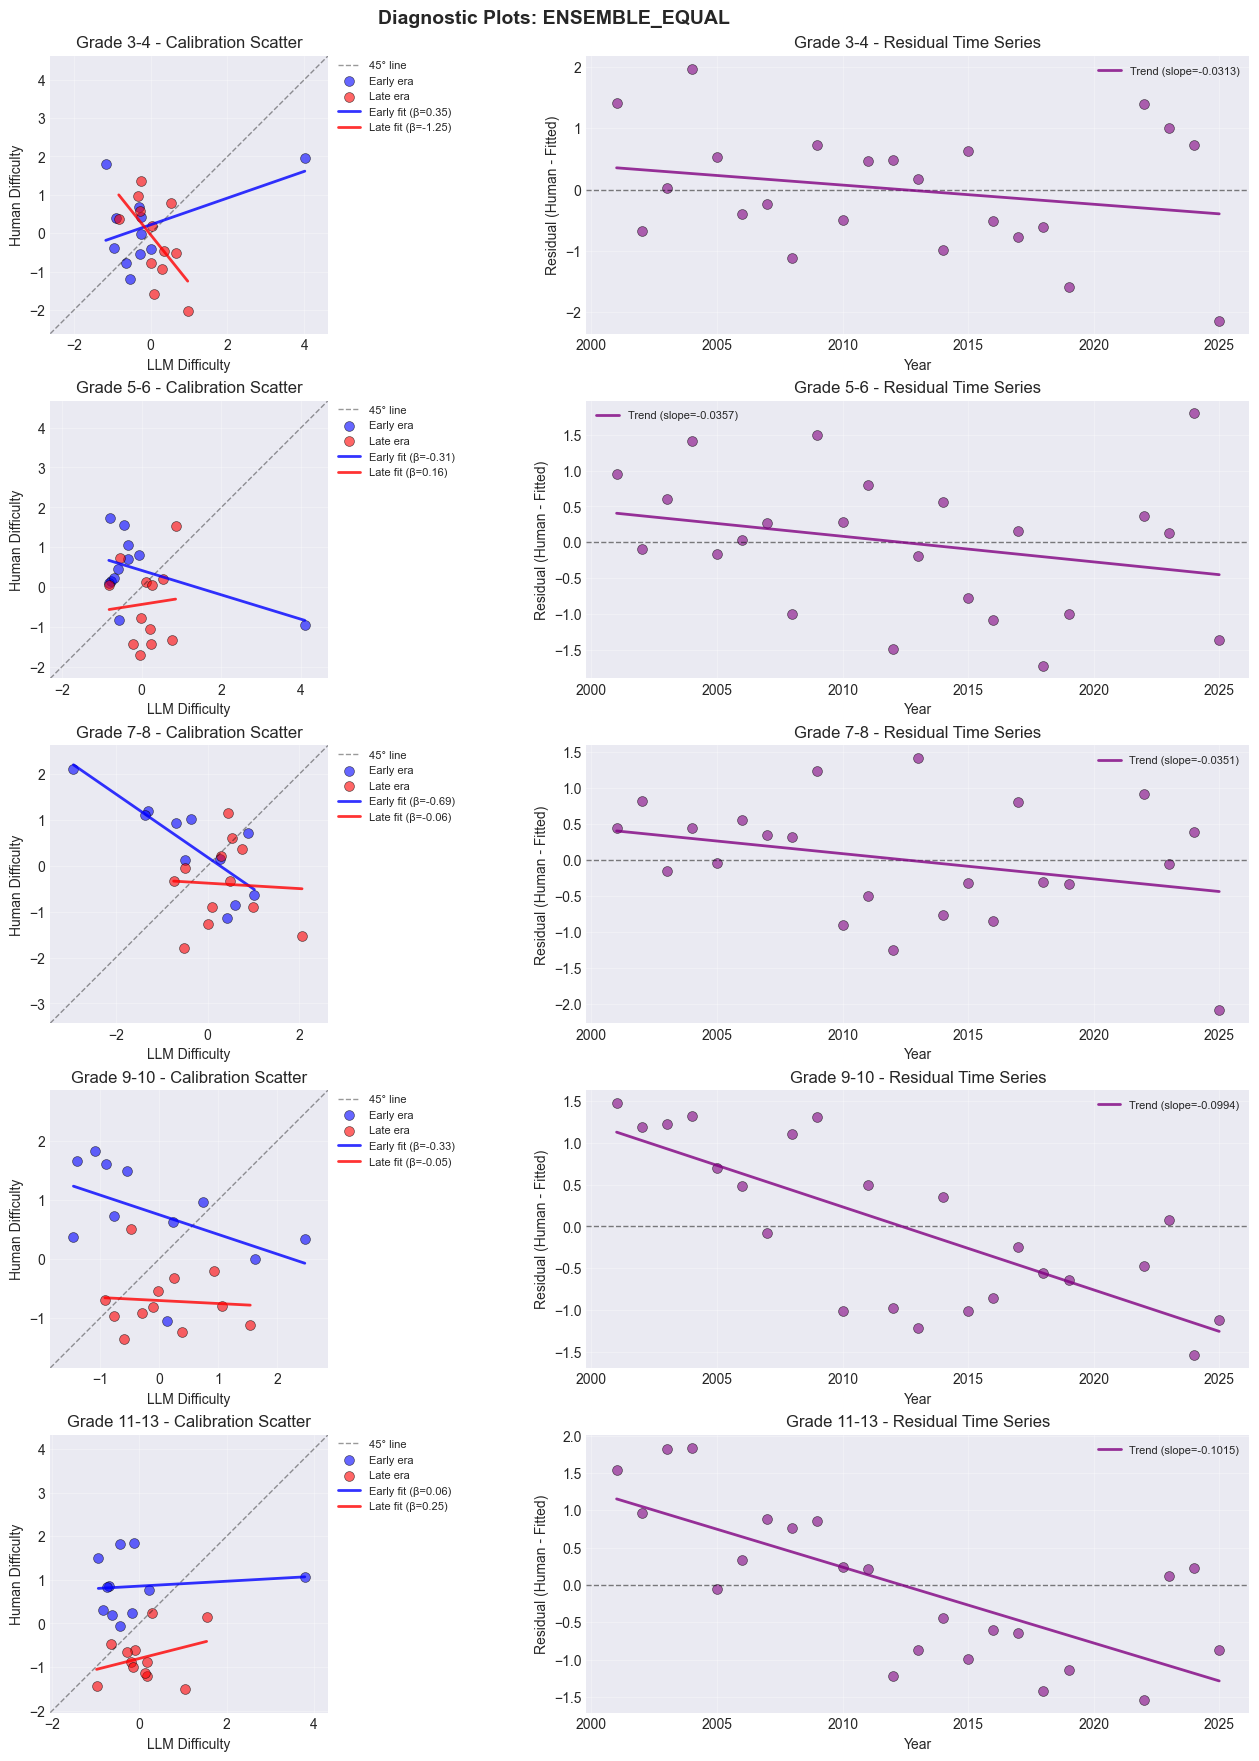

In [21]:
grades = sort_grade_buckets(analysis_df["grade_bucket"].unique().tolist())
series_to_plot = "ensemble_equal"
col_name = llm_series_to_test[series_to_plot]

fig, axes = plt.subplots(len(grades), 2, figsize=(14, 3.5 * len(grades)), constrained_layout=True)
if len(grades) == 1:
    axes = axes.reshape(1, -1)

for idx, grade in enumerate(grades):
    subset = analysis_df[analysis_df["grade_bucket"] == grade].sort_values("year").copy()
    years = subset["year"].to_numpy(dtype=float)
    human = subset["human_difficulty"].to_numpy(dtype=float)
    llm = subset[col_name].to_numpy(dtype=float)
    
    median_year = np.median(years)
    early_mask = years < median_year
    late_mask = years >= median_year
    
    ax_scatter = axes[idx, 0]
    ax_resid = axes[idx, 1]
    
    mask_valid = (~np.isnan(human)) & (~np.isnan(llm))
    if np.sum(mask_valid) > 0:
        lim_min = min(np.nanmin(human[mask_valid]), np.nanmin(llm[mask_valid]))
        lim_max = max(np.nanmax(human[mask_valid]), np.nanmax(llm[mask_valid]))
        lim_range = lim_max - lim_min
        lim_min -= 0.1 * lim_range
        lim_max += 0.1 * lim_range
        
        ax_scatter.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', alpha=0.4, linewidth=1, label='45° line')
        
        ax_scatter.scatter(llm[early_mask], human[early_mask], c='blue', alpha=0.6, s=50, label='Early era', edgecolors='k', linewidth=0.5)
        ax_scatter.scatter(llm[late_mask], human[late_mask], c='red', alpha=0.6, s=50, label='Late era', edgecolors='k', linewidth=0.5)
        
        if np.sum(early_mask) >= 2:
            X_early = llm[early_mask]
            y_early = human[early_mask]
            mask_e = (~np.isnan(X_early)) & (~np.isnan(y_early))
            if np.sum(mask_e) >= 2:
                coef_e = np.polyfit(X_early[mask_e], y_early[mask_e], 1)
                x_line = np.array([np.nanmin(X_early[mask_e]), np.nanmax(X_early[mask_e])])
                y_line = coef_e[0] * x_line + coef_e[1]
                ax_scatter.plot(x_line, y_line, 'b-', linewidth=2, alpha=0.8, label=f'Early fit (β={coef_e[0]:.2f})')
        
        if np.sum(late_mask) >= 2:
            X_late = llm[late_mask]
            y_late = human[late_mask]
            mask_l = (~np.isnan(X_late)) & (~np.isnan(y_late))
            if np.sum(mask_l) >= 2:
                coef_l = np.polyfit(X_late[mask_l], y_late[mask_l], 1)
                x_line = np.array([np.nanmin(X_late[mask_l]), np.nanmax(X_late[mask_l])])
                y_line = coef_l[0] * x_line + coef_l[1]
                ax_scatter.plot(x_line, y_line, 'r-', linewidth=2, alpha=0.8, label=f'Late fit (β={coef_l[0]:.2f})')
        
        ax_scatter.set_xlim(lim_min, lim_max)
        ax_scatter.set_ylim(lim_min, lim_max)
        ax_scatter.set_xlabel('LLM Difficulty')
        ax_scatter.set_ylabel('Human Difficulty')
        ax_scatter.set_title(f'{grade} - Calibration Scatter')
        ax_scatter.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
        ax_scatter.grid(alpha=0.3)
        ax_scatter.set_aspect('equal')
    
    if np.sum(mask_valid) >= 2:
        X_design = np.column_stack([np.ones(np.sum(mask_valid)), llm[mask_valid]])
        y_valid = human[mask_valid]
        coef = np.linalg.lstsq(X_design, y_valid, rcond=None)[0]
        y_pred = X_design @ coef
        residuals = y_valid - y_pred
        
        years_valid = years[mask_valid]
        ax_resid.scatter(years_valid, residuals, c='purple', alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
        ax_resid.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
        
        if len(residuals) >= 2:
            time_coef = np.polyfit(years_valid, residuals, 1)
            x_line = np.array([np.min(years_valid), np.max(years_valid)])
            y_line = time_coef[0] * x_line + time_coef[1]
            ax_resid.plot(x_line, y_line, 'purple', linewidth=2, alpha=0.8, label=f'Trend (slope={time_coef[0]:.4f})')
        
        ax_resid.set_xlabel('Year')
        ax_resid.set_ylabel('Residual (Human - Fitted)')
        ax_resid.set_title(f'{grade} - Residual Time Series')
        ax_resid.legend(fontsize=8)
        ax_resid.grid(alpha=0.3)

fig.suptitle(f'Diagnostic Plots: {series_to_plot.upper()}', fontsize=14, fontweight='bold')
plt.show()


In [22]:
loo_calibration_records = []
loo_decision_records = []

loo_difficulty_cols = [c for c in analysis_df.columns if c.startswith("difficulty_loo_")]

for grade, group in analysis_df.groupby("grade_bucket"):
    group = group.sort_values("year").copy()
    years = group["year"].to_numpy(dtype=float)
    years_centered = years - np.mean(years)
    human = group["human_difficulty"].to_numpy(dtype=float)
    
    for loo_col in loo_difficulty_cols:
        model_omitted = loo_col.replace("difficulty_loo_", "")
        llm_loo = group[loo_col].to_numpy(dtype=float)
        
        corr_val, corr_lo, corr_hi = bootstrap_corr(human, llm_loo)
        same_side = same_side_rate(human, llm_loo)
        peak_recall, peak_precision = peak_trough_recall(human, llm_loo, threshold=1.0)
        
        X_calib = llm_loo.reshape(-1, 1)
        calib = bootstrap_regression_coefs(X_calib, human, n_boot=2000)
        
        alpha = calib.get("intercept", (np.nan, np.nan, np.nan))
        beta = calib.get("coef_0", (np.nan, np.nan, np.nan))
        r2_calib = calib.get("r2", (np.nan, np.nan, np.nan))[0]
        
        X_time = np.column_stack([llm_loo, years_centered])
        time_model = bootstrap_regression_coefs(X_time, human, n_boot=2000)
        gamma = time_model.get("coef_1", (np.nan, np.nan, np.nan))
        
        loo_calibration_records.append({
            "grade_bucket": grade,
            "model_omitted": model_omitted,
            "correlation": corr_val,
            "same_side_rate": same_side,
            "peak_recall": peak_recall,
            "beta": beta[0],
            "gamma": gamma[0],
            "r2": r2_calib,
        })
        
        checks = {
            "corr_ok": corr_val >= THRESHOLDS["min_correlation"],
            "same_side_ok": same_side >= THRESHOLDS["min_same_side_rate"],
            "peak_recall_ok": peak_recall >= THRESHOLDS["min_peak_recall"],
            "beta_ok": THRESHOLDS["beta_min"] <= beta[0] <= THRESHOLDS["beta_max"],
        }
        
        passed = sum(checks.values())
        total = len(checks)
        
        if passed >= total * 0.75:
            verdict = "usable"
        elif passed >= total * 0.5:
            verdict = "uncertain"
        else:
            verdict = "not_usable"
        
        loo_decision_records.append({
            "grade_bucket": grade,
            "model_omitted": model_omitted,
            "correlation": corr_val,
            "beta": beta[0],
            "verdict": verdict,
        })

loo_calibration_df = pd.DataFrame(loo_calibration_records)
loo_calibration_df["_sort_key"] = loo_calibration_df["grade_bucket"].map(grade_sort_key)
loo_calibration_df = loo_calibration_df.sort_values(["_sort_key", "model_omitted"]).drop("_sort_key", axis=1).reset_index(drop=True)

loo_decision_df = pd.DataFrame(loo_decision_records)
loo_decision_df["_sort_key"] = loo_decision_df["grade_bucket"].map(grade_sort_key)
loo_decision_df = loo_decision_df.sort_values(["_sort_key", "model_omitted"]).drop("_sort_key", axis=1).reset_index(drop=True)

print("="*100)
print("LEAVE-ONE-OUT ROBUSTNESS ANALYSIS")
print("="*100)
print("\nCalibration metrics when each model is omitted from the ensemble:")
display(loo_calibration_df)

print("\n" + "="*100)
print("LOO VERDICT SUMMARY")
print("="*100)
loo_verdict_summary = loo_decision_df.groupby(["model_omitted", "verdict"]).size().unstack(fill_value=0)
print(loo_verdict_summary)
print("\nStability check: if verdicts are consistent across LOO variants, the ensemble is robust.")
print("If omitting one model changes verdicts substantially, that model is critical to the standard candle property.")



LEAVE-ONE-OUT ROBUSTNESS ANALYSIS

Calibration metrics when each model is omitted from the ensemble:


,grade_bucket,model_omitted,correlation,same_side_rate,peak_recall,beta,gamma,r2
0,Grade 3-4,anthropic-claude-sonnet-4.5,0.14,0.39,0.17,0.14,-0.03,0.02
1,Grade 3-4,openai-gpt-5,0.09,0.39,0.17,0.09,-0.03,0.01
2,Grade 3-4,qwen-qwen3-vl-235b-a22b-thinking,0.16,0.39,0.17,0.16,-0.03,0.03
3,Grade 3-4,x-ai-grok-4-fast,0.16,0.39,0.17,0.16,-0.03,0.03
4,Grade 5-6,anthropic-claude-sonnet-4.5,-0.25,0.30,0.11,-0.25,-0.04,0.06
5,Grade 5-6,openai-gpt-5,-0.31,0.26,0.00,-0.31,-0.04,0.10
6,Grade 5-6,qwen-qwen3-vl-235b-a22b-thinking,-0.35,0.35,0.00,-0.35,-0.04,0.12
7,Grade 5-6,x-ai-grok-4-fast,-0.29,0.39,0.00,-0.29,-0.04,0.08
8,Grade 7-8,anthropic-claude-sonnet-4.5,-0.54,0.35,0.00,-0.54,-0.05,0.30
9,Grade 7-8,openai-gpt-5,-0.58,0.39,0.00,-0.58,-0.04,0.34



LOO VERDICT SUMMARY
verdict                           not_usable
model_omitted                               
anthropic-claude-sonnet-4.5                5
openai-gpt-5                               5
qwen-qwen3-vl-235b-a22b-thinking           5
x-ai-grok-4-fast                           5

Stability check: if verdicts are consistent across LOO variants, the ensemble is robust.
If omitting one model changes verdicts substantially, that model is critical to the standard candle property.


## Final Conclusions

Based on the standard candle analysis, we evaluate whether LLMs can reliably measure exam difficulty over time.


In [23]:
print("="*100)
print("FINAL STANDARD CANDLE VERDICT")
print("="*100)

print("\n1. PER-GRADE ANALYSIS")
print("-" * 100)

for grade in sort_grade_buckets(decision_df["grade_bucket"].unique().tolist()):
    print(f"\n{grade}:")
    grade_subset = decision_df[decision_df["grade_bucket"] == grade]
    
    for _, row in grade_subset.iterrows():
        print(f"  {row['llm_series']}: {row['verdict'].upper()}")
        print(f"    - Correlation: {row['correlation']:.3f}")
        print(f"    - Same-side rate: {row['same_side_rate']:.3f}")
        print(f"    - Peak recall: {row['peak_recall']:.3f}")
        print(f"    - Calibration β: {row['beta']:.3f}")
        print(f"    - Time trend γ: {row['gamma']:.4f}")
        print(f"    - Out-of-sample R²: {row['oos_r2']:.3f}")

print("\n" + "="*100)
print("2. OVERALL SUMMARY")
print("-" * 100)

anchor_verdicts = decision_df[decision_df["llm_series"] == "anchor"]["verdict"].value_counts()
ensemble_equal_verdicts = decision_df[decision_df["llm_series"] == "ensemble_equal"]["verdict"].value_counts()

print("\nAnchor model (openai-gpt-5):")
print(f"  Usable: {anchor_verdicts.get('usable', 0)} grades")
print(f"  Uncertain: {anchor_verdicts.get('uncertain', 0)} grades")
print(f"  Not usable: {anchor_verdicts.get('not_usable', 0)} grades")

print("\nEqual-weight ensemble:")
print(f"  Usable: {ensemble_equal_verdicts.get('usable', 0)} grades")
print(f"  Uncertain: {ensemble_equal_verdicts.get('uncertain', 0)} grades")
print(f"  Not usable: {ensemble_equal_verdicts.get('not_usable', 0)} grades")

print("\n" + "="*100)
print("3. KEY FINDINGS")
print("-" * 100)

avg_corr_by_series = decision_df.groupby("llm_series")["correlation"].mean()
print("\nAverage correlation with human difficulty:")
for series, corr in avg_corr_by_series.items():
    print(f"  {series}: {corr:.3f}")

print("\nCalibration stability (early vs late era):")
avg_delta_beta = calibration_df.groupby("llm_series")["delta_beta"].apply(lambda x: np.mean(np.abs(x)))
for series, delta in avg_delta_beta.items():
    print(f"  {series}: mean |Δβ| = {delta:.3f}")

print("\nTemporal invariance:")
gamma_excludes_zero = calibration_df.apply(
    lambda row: row["gamma_ci_lo"] <= 0 <= row["gamma_ci_hi"], axis=1
)
for series in llm_series_to_test.keys():
    subset = calibration_df[calibration_df["llm_series"] == series]
    passes = gamma_excludes_zero[subset.index].sum()
    total = len(subset)
    print(f"  {series}: {passes}/{total} grades have γ CI including 0")

print("\n" + "="*100)
print("4. INTERPRETATION")
print("-" * 100)

ensemble_usable = ensemble_equal_verdicts.get('usable', 0)
total_grades = len(decision_df[decision_df["llm_series"] == "ensemble_equal"])

if ensemble_usable == total_grades:
    interpretation = "LLMs can serve as a reliable standard candle across all grade buckets."
elif ensemble_usable >= total_grades * 0.6:
    interpretation = "LLMs show promise as a standard candle but with grade-dependent reliability."
elif ensemble_usable >= total_grades * 0.3:
    interpretation = "LLMs have limited utility as a standard candle, reliable only for specific grades."
else:
    interpretation = "LLMs are not suitable as a standard candle for this dataset."

print(f"\n{interpretation}")

print("\n" + "="*100)
print("5. ASSUMPTIONS AND LIMITATIONS")
print("-" * 100)
print("""
Limitations:
- Limited sample size (~23 years per grade)
- Missing data for years 2020-2021
- Thresholds are set heuristically and could be adjusted
""")


FINAL STANDARD CANDLE VERDICT

1. PER-GRADE ANALYSIS
----------------------------------------------------------------------------------------------------

Grade 3-4:
  anchor: NOT_USABLE
    - Correlation: 0.265
    - Same-side rate: 0.435
    - Peak recall: 0.167
    - Calibration β: 0.265
    - Time trend γ: -0.0243
    - Out-of-sample R²: -0.152
  ensemble_equal: NOT_USABLE
    - Correlation: 0.138
    - Same-side rate: 0.348
    - Peak recall: 0.167
    - Calibration β: 0.138
    - Time trend γ: -0.0313
    - Out-of-sample R²: -0.400

Grade 5-6:
  anchor: NOT_USABLE
    - Correlation: -0.243
    - Same-side rate: 0.435
    - Peak recall: 0.000
    - Calibration β: -0.243
    - Time trend γ: -0.0441
    - Out-of-sample R²: -0.916
  ensemble_equal: NOT_USABLE
    - Correlation: -0.301
    - Same-side rate: 0.348
    - Peak recall: 0.000
    - Calibration β: -0.301
    - Time trend γ: -0.0396
    - Out-of-sample R²: -0.724

Grade 7-8:
  anchor: NOT_USABLE
    - Correlation: -0.278
   

## Composition Effects Analysis

Testing whether exam structure variables (multimodal share, point distribution) affect the LLM-human calibration.


In [24]:
print("="*100)
print("COMPOSITION EFFECTS ANALYSIS")
print("="*100)

composition_records = []

for grade, group in analysis_df.groupby("grade_bucket"):
    group = group.sort_values("year").copy()
    human = group["human_difficulty"].to_numpy(dtype=float)
    
    for series_name, col_name in llm_series_to_test.items():
        llm = group[col_name].to_numpy(dtype=float)
        multimodal_share = group["multimodal_share"].to_numpy(dtype=float)
        share_5pt = group["share_5pt"].to_numpy(dtype=float)
        share_3pt = group["share_3pt"].to_numpy(dtype=float)
        
        X_base = llm.reshape(-1, 1)
        base_model = bootstrap_regression_coefs(X_base, human, n_boot=2000)
        beta_base = base_model.get("coef_0", (np.nan, np.nan, np.nan))
        r2_base = base_model.get("r2", (np.nan, np.nan, np.nan))[0]
        
        X_comp = np.column_stack([llm, multimodal_share, share_5pt])
        comp_model = bootstrap_regression_coefs(X_comp, human, n_boot=2000)
        beta_comp = comp_model.get("coef_0", (np.nan, np.nan, np.nan))
        r2_comp = comp_model.get("r2", (np.nan, np.nan, np.nan))[0]
        coef_multimodal = comp_model.get("coef_1", (np.nan, np.nan, np.nan))
        coef_share5pt = comp_model.get("coef_2", (np.nan, np.nan, np.nan))
        
        delta_beta = beta_comp[0] - beta_base[0]
        delta_r2 = r2_comp - r2_base
        
        composition_records.append({
            "grade_bucket": grade,
            "llm_series": series_name,
            "beta_base": beta_base[0],
            "beta_base_ci_lo": beta_base[1],
            "beta_base_ci_hi": beta_base[2],
            "r2_base": r2_base,
            "beta_comp": beta_comp[0],
            "beta_comp_ci_lo": beta_comp[1],
            "beta_comp_ci_hi": beta_comp[2],
            "r2_comp": r2_comp,
            "coef_multimodal": coef_multimodal[0],
            "coef_share5pt": coef_share5pt[0],
            "delta_beta": delta_beta,
            "delta_r2": delta_r2,
        })

composition_df = pd.DataFrame(composition_records)
composition_df["_sort_key"] = composition_df["grade_bucket"].map(grade_sort_key)
composition_df = composition_df.sort_values(["_sort_key", "llm_series"]).drop("_sort_key", axis=1).reset_index(drop=True)

print("\nComparison of base calibration vs composition-controlled calibration:")
print("(human_difficulty = α + β_base * llm_difficulty)")
print("vs")
print("(human_difficulty = α + β_comp * llm_difficulty + γ₁ * multimodal_share + γ₂ * share_5pt)")
print()

display(composition_df[[
    "grade_bucket", "llm_series", 
    "beta_base", "r2_base", 
    "beta_comp", "r2_comp",
    "coef_multimodal", "coef_share5pt",
    "delta_beta", "delta_r2"
]])

print("\n" + "="*100)
print("INTERPRETATION")
print("-" * 100)
print("""
If β changes substantially when adding composition controls (|Δβ| > 0.2), then exam structure
affects the LLM-human relationship, suggesting the LLM's difficulty assessment is sensitive
to exam format rather than solely cognitive difficulty.

If R² improves significantly (ΔR² > 0.1), composition variables explain additional variance,
indicating that LLMs respond differently to multimodal or high-point-value questions.

Small changes in β and R² suggest the calibration is robust to exam composition differences.
""")

avg_delta_beta_abs = composition_df.groupby("llm_series")["delta_beta"].apply(lambda x: np.mean(np.abs(x)))
avg_delta_r2 = composition_df.groupby("llm_series")["delta_r2"].mean()

print("\nAverage impact of composition controls:")
for series in llm_series_to_test.keys():
    db = avg_delta_beta_abs.get(series, np.nan)
    dr = avg_delta_r2.get(series, np.nan)
    print(f"  {series}: mean |Δβ| = {db:.3f}, mean ΔR² = {dr:.3f}")


COMPOSITION EFFECTS ANALYSIS

Comparison of base calibration vs composition-controlled calibration:
(human_difficulty = α + β_base * llm_difficulty)
vs
(human_difficulty = α + β_comp * llm_difficulty + γ₁ * multimodal_share + γ₂ * share_5pt)



,grade_bucket,llm_series,beta_base,r2_base,beta_comp,r2_comp,coef_multimodal,coef_share5pt,delta_beta,delta_r2
0,Grade 3-4,anchor,0.26,0.07,0.25,0.12,-1.39,6.24,-0.01,0.05
1,Grade 3-4,ensemble_equal,0.14,0.02,0.17,0.08,-1.67,2.38,0.04,0.07
2,Grade 5-6,anchor,-0.24,0.06,0.15,0.23,-3.28,88.37,0.39,0.17
3,Grade 5-6,ensemble_equal,-0.30,0.09,0.21,0.23,-3.56,106.05,0.51,0.14
4,Grade 7-8,anchor,-0.28,0.08,-0.24,0.21,-2.68,0.35,0.04,0.14
5,Grade 7-8,ensemble_equal,-0.58,0.33,-0.50,0.39,-1.85,0.24,0.07,0.06
6,Grade 9-10,anchor,-0.33,0.11,-0.08,0.46,-5.94,-45.51,0.24,0.36
7,Grade 9-10,ensemble_equal,-0.31,0.10,0.04,0.46,-6.40,-49.90,0.35,0.36
8,Grade 11-13,anchor,-0.02,0.00,0.05,0.22,-6.16,0.72,0.08,0.22
9,Grade 11-13,ensemble_equal,0.03,0.00,0.13,0.24,-6.38,0.75,0.10,0.24



INTERPRETATION
----------------------------------------------------------------------------------------------------

If β changes substantially when adding composition controls (|Δβ| > 0.2), then exam structure
affects the LLM-human relationship, suggesting the LLM's difficulty assessment is sensitive
to exam format rather than solely cognitive difficulty.

If R² improves significantly (ΔR² > 0.1), composition variables explain additional variance,
indicating that LLMs respond differently to multimodal or high-point-value questions.

Small changes in β and R² suggest the calibration is robust to exam composition differences.


Average impact of composition controls:
  anchor: mean |Δβ| = 0.153, mean ΔR² = 0.186
  ensemble_equal: mean |Δβ| = 0.214, mean ΔR² = 0.171


In [25]:
analysis_df.head()

,year,exam,grade_bucket,ensemble_pct_equal,model_count,anchor_pct,ensemble_pct_equal_loo_anthropic-claude-sonnet-4.5,ensemble_pct_equal_loo_openai-gpt-5,ensemble_pct_equal_loo_qwen-qwen3-vl-235b-a22b-thinking,ensemble_pct_equal_loo_x-ai-grok-4-fast,...,ensemble_pct_comp_resid,ensemble_comp_z,difficulty_comp,difficulty_loo_anthropic-claude-sonnet-4.5,difficulty_loo_openai-gpt-5,difficulty_loo_qwen-qwen3-vl-235b-a22b-thinking,difficulty_loo_x-ai-grok-4-fast,difficulty_equal_std,difficulty_equal_ci_lo,difficulty_equal_ci_hi
0,2001,3-4,Grade 3-4,19.62,4,17.82,19.44,20.22,20.60,18.21,...,-56.79,-4.20,4.20,4.07,3.79,3.91,4.12,0.20,3.82,4.21
1,2002,3-4,Grade 3-4,83.22,4,86.11,83.80,82.25,81.10,85.73,...,7.49,0.55,-0.55,-0.65,-0.66,-0.54,-0.65,0.37,-1.00,-0.27
2,2003,3-4,Grade 3-4,77.97,4,73.30,76.29,79.53,76.29,79.77,...,-0.00,0.00,-0.00,-0.10,-0.46,-0.18,-0.23,0.36,-0.60,0.10
3,2004,3-4,Grade 3-4,90.57,4,95.37,90.51,88.97,89.35,93.44,...,15.53,1.15,-1.15,-1.14,-1.14,-1.14,-1.20,0.38,-1.54,-0.80
4,2005,3-4,Grade 3-4,86.75,4,87.27,85.42,86.57,85.42,89.58,...,11.71,0.87,-0.87,-0.77,-0.97,-0.85,-0.93,0.37,-1.25,-0.53
